# 퀀트비율조정_RAG
* 금융보고서를 전처리한 후 질문과 관련된 문서를 가져온다
* 퀀트 리스크패리티 추세 데이터를 보여주고 종목 비율 조정 추천을 받거나 다양한 피드백을 받는다.

In [6]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# API 키 정보 로드
load_dotenv()

True

In [7]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("퀀트비율조정_RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
퀀트비율조정_RAG


## **** 모든 문서 합치고 토큰수 확인 ****

`doc`은 PDF 파일입니다. 토큰 수는 100 토큰 미만에서 10,000 토큰 이상까지 다양합니다.

웹 문서에서 텍스트 데이터를 추출하고, 텍스트의 토큰 수를 계산하여 히스토그램으로 시각화합니다.

In [8]:
import os

folder_path = "reports"  # PDF들이 있는 폴더 경로

pdf_files = [f for f in os.listdir(folder_path) if f.endswith(".pdf")]

# 전체 경로로 만들기 (선택)
pdf_paths = [os.path.join(folder_path, f) for f in pdf_files]

print(pdf_paths)

['reports\\20250728_invest_463167000.pdf', 'reports\\20250728_invest_582328000.pdf', 'reports\\20250728_invest_764144000.pdf', 'reports\\20250728_invest_917031000.pdf']


In [9]:
### PDF 파일 병합하기

import fitz  # PyMuPDF
import os

# 병합된 PDF 저장 경로
os.makedirs("merged_PDF", exist_ok=True)
merged_pdf_path = "merged_PDF/combined.pdf"

# PDF 병합 수행
with fitz.open() as merged_pdf:
    for path in pdf_paths:
        # 각 PDF 열기
        src = fitz.open(path)
        # 원본 PDF를 병합 대상에 붙이기
        merged_pdf.insert_pdf(src)
        src.close()

    # 병합된 PDF 저장
    merged_pdf.save(merged_pdf_path)

print(f"✅ 병합 완료: {merged_pdf_path}")

✅ 병합 완료: merged_PDF/combined.pdf


In [10]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt


# tiktoken은 OpenAI 토큰 인코딩 도구
# "cl100k_base" 같은 이름을 넘기면 해당 모델에 맞는 **토큰화 방식(encoding)**을 가져옴
# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# 문서 로드(Load Documents)
loader = PDFPlumberLoader(merged_pdf_path)
docs = loader.load()
print(f"문서의 페이지수: {len(docs)}")

문서의 페이지수: 21


In [11]:
docs

[Document(metadata={'source': 'merged_PDF/combined.pdf', 'file_path': 'merged_PDF/combined.pdf', 'page': 0, 'total_pages': 21}, page_content='2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀\n관세, 매크로, 실적, 3대 이벤트 쏠림 구간\n한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM\n제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국\nM7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내\n주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망\n(주간 코스피 예상 레인지 3,150~3,250pt).\n한-미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및\n자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해\n주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가\n생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.\n국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무\n풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이\n후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨\n퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격\n등)가 향후 주가 향방의 변수가 될 전망.\n| Strategist 한지영 | Market/ESG 이성훈\nhedge0301@kiwoom.com shl076@kiwoom.com\nCompliance Notice\n- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다\n- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.\n- 동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 

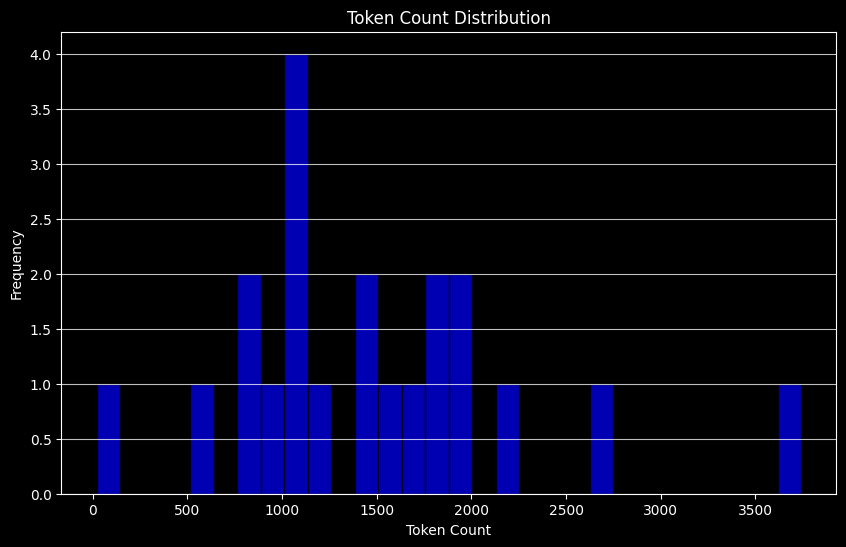

In [12]:
# 문서 텍스트
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show()

## **** 주주총회 8월달 내용 - Document_Graph_parser ****

In [13]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    filepath: str  # path
    filetype: str  # pdf
    page_numbers: list[int]  # page numbers
    batch_size: int  # batch size
    split_filepaths: list[str]  # split files
    analyzed_files: list[str]  # analyzed files
    page_elements: dict[int, dict[str, list[dict]]]  # page elements
    page_metadata: dict[int, dict]  # page metadata
    page_summary: dict[int, str]  # page summary
    images: list[str]  # image paths
    images_summary: list[str]  # image summary
    tables: list[str]  # table
    tables_summary: dict[int, str]  # table summary
    texts: list[str]  # text
    texts_summary: list[str]  # text summary

#### 1. 문서를 배치 단위로 분할 (10 page)

In [14]:
import os
import pymupdf
import json
import requests
from PIL import Image

In [15]:
def split_pdf(state: GraphState):
    """
    입력 PDF를 여러 개의 작은 PDF 파일로 분할합니다.

    :param state: GraphState 객체, PDF 파일 경로와 배치 크기 정보를 포함
    :return: 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체
    """
    # PDF 파일 경로와 배치 크기 추출
    filepath = state["filepath"]
    batch_size = state["batch_size"]

    # PDF 파일 열기
    input_pdf = pymupdf.open(filepath)
    num_pages = len(input_pdf)
    print(f"총 페이지 수: {num_pages}")

    ret = []
    # PDF 분할 작업 시작
    for start_page in range(0, num_pages, batch_size):
        # 배치의 마지막 페이지 계산 (전체 페이지 수를 초과하지 않도록)
        end_page = min(start_page + batch_size, num_pages) - 1

        # 분할된 PDF 파일명 생성
        input_file_basename = os.path.splitext(filepath)[0]
        output_file = f"{input_file_basename}_{start_page:04d}_{end_page:04d}.pdf"
        print(f"분할 PDF 생성: {output_file}")

        # 새로운 PDF 파일 생성 및 페이지 삽입
        with pymupdf.open() as output_pdf:
            output_pdf.insert_pdf(input_pdf, from_page=start_page, to_page=end_page)
            # insert_pdf()는 다른 PDF에서 일부 페이지를 가져와서 현재 PDF에 붙이는 함수
            output_pdf.save(output_file)
            ret.append(output_file)

    # 원본 PDF 파일 닫기
    input_pdf.close()

    # 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체 반환
    return GraphState(split_filepaths=ret)

In [16]:
state = GraphState(filepath=merged_pdf_path, batch_size=10)
state_out = split_pdf(state)
state.update(state_out)
state

총 페이지 수: 21
분할 PDF 생성: merged_PDF/combined_0000_0009.pdf
분할 PDF 생성: merged_PDF/combined_0010_0019.pdf
분할 PDF 생성: merged_PDF/combined_0020_0020.pdf


{'filepath': 'merged_PDF/combined.pdf',
 'batch_size': 10,
 'split_filepaths': ['merged_PDF/combined_0000_0009.pdf',
  'merged_PDF/combined_0010_0019.pdf',
  'merged_PDF/combined_0020_0020.pdf']}

#### 2. Layout Analyzer 를 사용하여 문서를 element 단위로 분할
* LayoutAnalyzer 클래스는 Upstage의 문서 레이아웃 분석 API를 호출해서,
* PDF 문서를 분석하고 그 결과를 JSON 파일로 저장하는 기능

In [17]:
class LayoutAnalyzer:
    def __init__(self, api_key):
        """
        LayoutAnalyzer 클래스의 생성자

        :param api_key: Upstage API 인증을 위한 API 키
        """
        self.api_key = api_key

    def _upstage_layout_analysis(self, input_file):
        """
        Upstage의 레이아웃 분석 API를 호출하여 문서 분석을 수행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        # API 요청 헤더 설정
        headers = {"Authorization": f"Bearer {self.api_key}"}

        # API 요청 데이터 설정 (OCR 비활성화)
        data = {"ocr": False}

        # 분석할 PDF 파일 열기
        files = {"document": open(input_file, "rb")}

        # API 요청 보내기
        response = requests.post(
            "https://api.upstage.ai/v1/document-ai/layout-analysis",
            headers=headers,
            data=data,
            files=files,
        )

        # API 응답 처리 및 결과 저장
        if response.status_code == 200:
            # 분석 결과를 저장할 JSON 파일 경로 생성
            output_file = os.path.splitext(input_file)[0] + ".json"

            # 분석 결과를 JSON 파일로 저장
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(response.json(), f, ensure_ascii=False)

            return output_file
        else:
            # API 요청이 실패한 경우 예외 발생
            raise ValueError(f"API 요청 실패. 상태 코드: {response.status_code}")

    def execute(self, input_file):
        """
        주어진 입력 파일에 대해 레이아웃 분석을 실행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        return self._upstage_layout_analysis(input_file)

In [18]:
def analyze_layout(state: GraphState):
    # 분할된 PDF 파일 목록을 가져옵니다.
    split_files = state["split_filepaths"]

    # LayoutAnalyzer 객체를 생성합니다. API 키는 환경 변수에서 가져옵니다.
    analyzer = LayoutAnalyzer(os.environ.get("UPSTAGE_API_KEY"))

    # 분석된 파일들의 경로를 저장할 리스트를 초기화합니다.
    analyzed_files = []

    # 각 분할된 PDF 파일에 대해 레이아웃 분석을 수행합니다.
    for file in split_files:
        # 레이아웃 분석을 실행하고 결과 파일 경로를 리스트에 추가합니다.
        analyzed_files.append(analyzer.execute(file))

    # 분석된 파일 경로들을 정렬하여 새로운 GraphState 객체를 생성하고 반환합니다.
    # 정렬은 파일들의 순서를 유지하기 위해 수행됩니다.
    return GraphState(analyzed_files=sorted(analyzed_files))

In [19]:
state_out = analyze_layout(state)
state.update(state_out)
state

##### 분석 결과가 저장된 JSON 파일에는 문서 안의 요소들(텍스트, 표, 이미지 등)의 위치와 유형 정보가 들어 있음 → 나중에 페이지 요약, 테이블 추출 등에 활용할 수 있음 !!!

{'filepath': 'merged_PDF/combined.pdf',
 'batch_size': 10,
 'split_filepaths': ['merged_PDF/combined_0000_0009.pdf',
  'merged_PDF/combined_0010_0019.pdf',
  'merged_PDF/combined_0020_0020.pdf'],
 'analyzed_files': ['merged_PDF/combined_0000_0009.json',
  'merged_PDF/combined_0010_0019.json',
  'merged_PDF/combined_0020_0020.json']}

In [20]:
with open("merged_PDF/combined_0000_0009.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(data["metadata"])

{'pages': [{'height': 1595, 'page': 1, 'width': 1123}, {'height': 1595, 'page': 2, 'width': 1123}, {'height': 1595, 'page': 3, 'width': 1123}, {'height': 1595, 'page': 4, 'width': 1123}, {'height': 1595, 'page': 5, 'width': 1123}, {'height': 1595, 'page': 6, 'width': 1123}, {'height': 1595, 'page': 7, 'width': 1123}, {'height': 1595, 'page': 8, 'width': 1123}, {'height': 1595, 'page': 9, 'width': 1123}, {'height': 1754, 'page': 10, 'width': 1241}]}


In [21]:
print(data.keys())

dict_keys(['api', 'billed_pages', 'elements', 'html', 'metadata', 'mimetype', 'model', 'text'])


In [22]:
print(data["elements"][:100])

[{'bounding_box': [{'x': 402, 'y': 295}, {'x': 668, 'y': 295}, {'x': 668, 'y': 351}, {'x': 402, 'y': 351}], 'category': 'paragraph', 'html': "<p id='0' data-category='paragraph' style='font-size:20px'>2025년 7월 28일<br>키움증권 리서치센터 | 투자전략팀</p>", 'id': 0, 'page': 1, 'text': '2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀'}, {'bounding_box': [{'x': 413, 'y': 495}, {'x': 903, 'y': 495}, {'x': 903, 'y': 529}, {'x': 413, 'y': 529}], 'category': 'heading1', 'html': "<h1 id='1' style='font-size:22px'>관세, 매크로, 실적, 3대 이벤트 쏠림 구간</h1>", 'id': 1, 'page': 1, 'text': '관세, 매크로, 실적, 3대 이벤트 쏠림 구간'}, {'bounding_box': [{'x': 408, 'y': 545}, {'x': 961, 'y': 545}, {'x': 961, 'y': 688}, {'x': 408, 'y': 688}], 'category': 'paragraph', 'html': "<br><p id='2' data-category='paragraph' style='font-size:20px'>한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM<br>제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국<br>M7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내<br>주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망<br>(주간 코스피 예상 레인지 3,150~3,250pt).</p>", 'id': 

#### 3. Upstage의 문서 레이아웃 분석 API로 얻은 JSON 파일에서 다양한 속성을 추출하여 state 업데이트하기
* (1) 사이즈 속성 추가하기

In [23]:
import re


def extract_start_end_page(filename):
    """
    파일 이름에서 시작 페이지와 끝 페이지 번호를 추출하는 함수입니다.

    :param filename: 분석할 파일의 이름
    :return: 시작 페이지 번호와 끝 페이지 번호를 튜플로 반환
    """
    # 파일 경로에서 파일 이름만 추출
    file_name = os.path.basename(filename)
    # 파일 이름을 '_' 기준으로 분리
    file_name_parts = file_name.split("_")

    if len(file_name_parts) >= 3:
        # 파일 이름의 뒤에서 두 번째 부분에서 숫자를 추출하여 시작 페이지로 설정
        start_page = int(re.findall(r"(\d+)", file_name_parts[-2])[0])
        # 파일 이름의 마지막 부분에서 숫자를 추출하여 끝 페이지로 설정
        end_page = int(re.findall(r"(\d+)", file_name_parts[-1])[0])
    else:
        # 파일 이름 형식이 예상과 다를 경우 기본값 설정
        start_page, end_page = 0, 0

    return start_page, end_page


def extract_page_metadata(state: GraphState):
    """
    분석된 JSON 파일들에서 페이지 메타데이터를 추출하는 함수입니다.

    :param state: 현재의 GraphState 객체
    :return: 페이지 메타데이터가 추가된 새로운 GraphState 객체
    """
    # 분석된 JSON 파일 목록 가져오기
    json_files = state["analyzed_files"]

    # 페이지 메타데이터를 저장할 딕셔너리 초기화
    page_metadata = dict()

    for json_file in json_files:
        # JSON 파일 열기 및 데이터 로드
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 파일명에서 시작 페이지 번호 추출
        start_page, _ = extract_start_end_page(json_file)

        # JSON 데이터에서 각 페이지의 메타데이터 추출
        for element in data["metadata"]["pages"]:
            # 원본 페이지 번호
            original_page = int(element["page"])
            # 상대적 페이지 번호 계산 (전체 문서 기준)
            relative_page = start_page + original_page - 1

            # 페이지 크기 정보 추출
            metadata = {
                "size": [
                    int(element["width"]),
                    int(element["height"]),
                ],
            }
            # 상대적 페이지 번호를 키로 하여 메타데이터 저장
            page_metadata[relative_page] = metadata

    # 추출된 페이지 메타데이터로 새로운 GraphState 객체 생성 및 반환
    return GraphState(page_metadata=page_metadata)

In [24]:
state_out = extract_page_metadata(state)
state.update(state_out)
state["page_metadata"]

{0: {'size': [1123, 1595]},
 1: {'size': [1123, 1595]},
 2: {'size': [1123, 1595]},
 3: {'size': [1123, 1595]},
 4: {'size': [1123, 1595]},
 5: {'size': [1123, 1595]},
 6: {'size': [1123, 1595]},
 7: {'size': [1123, 1595]},
 8: {'size': [1123, 1595]},
 9: {'size': [1241, 1754]},
 10: {'size': [1241, 1754]},
 11: {'size': [1241, 1754]},
 12: {'size': [1241, 1754]},
 13: {'size': [1241, 1754]},
 14: {'size': [1241, 1754]},
 15: {'size': [1241, 1754]},
 16: {'size': [1241, 1754]},
 17: {'size': [1241, 1754]},
 18: {'size': [1241, 1754]},
 19: {'size': [1241, 1754]},
 20: {'size': [1241, 1754]}}

In [25]:
state["analyzed_files"]

['merged_PDF/combined_0000_0009.json',
 'merged_PDF/combined_0010_0019.json',
 'merged_PDF/combined_0020_0020.json']

* (2) 페이지별 HTML Element 추출하여 state page_elements에 추가하기

In [26]:
def extract_page_elements(state: GraphState):
    # 분석된 JSON 파일 목록을 가져옵니다.
    json_files = state["analyzed_files"]

    # 페이지별 요소를 저장할 딕셔너리를 초기화합니다.
    page_elements = dict()

    # 전체 문서에서 고유한 요소 ID를 부여하기 위한 카운터입니다.
    element_id = 0

    # 각 JSON 파일을 순회하며 처리합니다.
    for json_file in json_files:
        # 파일명에서 시작 페이지 번호를 추출합니다.
        start_page, _ = extract_start_end_page(json_file)

        # JSON 파일을 열어 데이터를 로드합니다.
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # JSON 데이터의 각 요소를 처리합니다.
        for element in data["elements"]:
            # 원본 페이지 번호를 정수로 변환합니다.
            original_page = int(element["page"])
            # 전체 문서 기준의 상대적 페이지 번호를 계산합니다.
            relative_page = start_page + original_page - 1

            # 해당 페이지의 요소 리스트가 없으면 새로 생성합니다.
            if relative_page not in page_elements:
                page_elements[relative_page] = []

            # 요소에 고유 ID를 부여합니다.
            element["id"] = element_id
            element_id += 1

            # 요소의 페이지 번호를 상대적 페이지 번호로 업데이트합니다.
            element["page"] = relative_page
            # 요소를 해당 페이지의 리스트에 추가합니다.
            page_elements[relative_page].append(element)

    # 추출된 페이지별 요소 정보로 새로운 GraphState 객체를 생성하여 반환합니다.
    return GraphState(page_elements=page_elements)

In [27]:
state_out = extract_page_elements(state)
state.update(state_out)
state["page_elements"][0]

[{'bounding_box': [{'x': 402, 'y': 295},
   {'x': 668, 'y': 295},
   {'x': 668, 'y': 351},
   {'x': 402, 'y': 351}],
  'category': 'paragraph',
  'html': "<p id='0' data-category='paragraph' style='font-size:20px'>2025년 7월 28일<br>키움증권 리서치센터 | 투자전략팀</p>",
  'id': 0,
  'page': 0,
  'text': '2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀'},
 {'bounding_box': [{'x': 413, 'y': 495},
   {'x': 903, 'y': 495},
   {'x': 903, 'y': 529},
   {'x': 413, 'y': 529}],
  'category': 'heading1',
  'html': "<h1 id='1' style='font-size:22px'>관세, 매크로, 실적, 3대 이벤트 쏠림 구간</h1>",
  'id': 1,
  'page': 0,
  'text': '관세, 매크로, 실적, 3대 이벤트 쏠림 구간'},
 {'bounding_box': [{'x': 408, 'y': 545},
   {'x': 961, 'y': 545},
   {'x': 961, 'y': 688},
   {'x': 408, 'y': 688}],
  'category': 'paragraph',
  'html': "<br><p id='2' data-category='paragraph' style='font-size:20px'>한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM<br>제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국<br>M7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내<br>주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 

In [28]:
state["page_elements"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

* (3) page_elements에 [images, tables, text] category를 분해하기

In [29]:
def extract_tag_elements_per_page(state: GraphState):
    # GraphState 객체에서 페이지 요소들을 가져옵니다.
    page_elements = state["page_elements"]

    # 파싱된 페이지 요소들을 저장할 새로운 딕셔너리를 생성합니다.
    parsed_page_elements = dict()

    # 각 페이지와 해당 페이지의 요소들을 순회합니다.
    for key, page_element in page_elements.items():
        # 이미지, 테이블, 텍스트 요소들을 저장할 리스트를 초기화합니다.
        image_elements = []
        table_elements = []
        text_elements = []
        chart_elements = []

        # 페이지의 각 요소를 순회하며 카테고리별로 분류합니다.
        for element in page_element:
            if element["category"] == "figure":
                # 이미지 요소인 경우 image_elements 리스트에 추가합니다.
                image_elements.append(element)
            elif element["category"] == "table":
                # 테이블 요소인 경우 table_elements 리스트에 추가합니다.
                table_elements.append(element)
            elif element["category"] == "chart":
                # 테이블 요소인 경우 table_elements 리스트에 추가합니다.
                chart_elements.append(element)
            else:
                # 그 외의 요소는 모두 텍스트 요소로 간주하여 text_elements 리스트에 추가합니다.
                text_elements.append(element)

        # 분류된 요소들을 페이지 키와 함께 새로운 딕셔너리에 저장합니다.
        parsed_page_elements[key] = {
            "image_elements": image_elements,
            "table_elements": table_elements,
            "chart_elements": chart_elements,
            "text_elements": text_elements,
            "elements": page_element,  # 원본 페이지 요소도 함께 저장합니다.
        }

    # 파싱된 페이지 요소들을 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(page_elements=parsed_page_elements)

In [30]:
state_out = extract_tag_elements_per_page(state)
state.update(state_out)

In [31]:
state["page_elements"][0].keys()

dict_keys(['image_elements', 'table_elements', 'chart_elements', 'text_elements', 'elements'])

In [32]:
state["page_elements"][0]["image_elements"]

[{'bounding_box': [{'x': 573, 'y': 1052},
   {'x': 782, 'y': 1052},
   {'x': 782, 'y': 1240},
   {'x': 573, 'y': 1240}],
  'category': 'figure',
  'html': '<figure id=\'4\'><img style=\'font-size:18px\' alt="| Strategist 한지영\nhedge0301@kiwoom.com" data-coord="top-left:(573,1052); bottom-right:(782,1240)" /></figure>',
  'id': 4,
  'page': 0,
  'text': '| Strategist 한지영\nhedge0301@kiwoom.com'},
 {'bounding_box': [{'x': 931, 'y': 1061},
   {'x': 1010, 'y': 1061},
   {'x': 1010, 'y': 1191},
   {'x': 931, 'y': 1191}],
  'category': 'figure',
  'html': '<br><figure id=\'5\'><img alt="" data-coord="top-left:(931,1061); bottom-right:(1010,1191)" /></figure>',
  'id': 5,
  'page': 0,
  'text': ''}]

In [33]:
state_out["page_elements"][2]["table_elements"]

[{'bounding_box': [{'x': 100, 'y': 255},
   {'x': 1046, 'y': 255},
   {'x': 1046, 'y': 1168},
   {'x': 100, 'y': 1168}],
  'category': 'table',
  'html': "<br><table id='28' style='font-size:16px'><thead><tr><td></td><td>국가</td><td>경제지표</td><td>대상</td><td>전망치</td><td>이전치</td></tr></thead><tbody><tr><td>7 월 28 일</td><td>월 미국 실적</td><td>댈러스 연준 제조업 활동 현대오토에버, 두산로보틱스</td><td>7 월</td><td>-</td><td>-12.7</td></tr><tr><td>7 월 29 일</td><td>화 미국 실적 실적</td><td>CB 소비자기대지수 JOLTs 구인건수 한화오션, 한화시스템, 한국항공우주, 크래프톤 비자, 유나이티드헬스, 보잉, 페이팔</td><td>7 월 6 월</td><td>95.9 -</td><td>93.0 7,769K</td></tr><tr><td>7 월 30 일</td><td>수 미국</td><td>GDP 성장률 (QoQ,잠정치) ADP 취업자 변동수</td><td>2 분기 7 월</td><td>2.5% 75K</td><td>-0.5% -33K</td></tr><tr><td></td><td>유로존 회의 실적</td><td>GDP 성장률 (YoY,잠정치) FOMC 회의</td><td>2 분기</td><td>- 4.25-4.50%</td><td>1.5% 4.25-4.50%</td></tr><tr><td>7 월 31 일</td><td>실적 목 미국</td><td>삼성물산, SKC 마이크로소프트, 메타, 퀄컴 PCE 물가 (YoY)</td><td>6 월</td><td>2.5%</td><td>2.3%</td></tr><tr><td></td><td></td><td>근원 PC

In [34]:
state["page_elements"][2]["text_elements"]

[{'bounding_box': [{'x': 270, 'y': 140},
   {'x': 405, 'y': 140},
   {'x': 405, 'y': 194},
   {'x': 270, 'y': 194}],
  'category': 'paragraph',
  'html': "<p id='26' data-category='paragraph' style='font-size:14px'>2025년 7월 28일<br>KIWOOM WEEKLY</p>",
  'id': 26,
  'page': 2,
  'text': '2025년 7월 28일\nKIWOOM WEEKLY'},
 {'bounding_box': [{'x': 100, 'y': 219},
   {'x': 368, 'y': 219},
   {'x': 368, 'y': 243},
   {'x': 100, 'y': 243}],
  'category': 'heading1',
  'html': "<h1 id='27' style='font-size:20px'>이번 주 주요 경제지표 발표 일정</h1>",
  'id': 27,
  'page': 2,
  'text': '이번 주 주요 경제지표 발표 일정'},
 {'bounding_box': [{'x': 99, 'y': 1175},
   {'x': 355, 'y': 1175},
   {'x': 355, 'y': 1195},
   {'x': 99, 'y': 1195}],
  'category': 'paragraph',
  'html': "<br><p id='29' data-category='paragraph' style='font-size:14px'>출 처: Bloomberg, 키움증권 리서치센터</p>",
  'id': 29,
  'page': 2,
  'text': '출 처: Bloomberg, 키움증권 리서치센터'},
 {'bounding_box': [{'x': 1021, 'y': 1517},
   {'x': 1036, 'y': 1517},
   {'x': 1036, 'y':

In [35]:
state["page_elements"]

{0: {'image_elements': [{'bounding_box': [{'x': 573, 'y': 1052},
     {'x': 782, 'y': 1052},
     {'x': 782, 'y': 1240},
     {'x': 573, 'y': 1240}],
    'category': 'figure',
    'html': '<figure id=\'4\'><img style=\'font-size:18px\' alt="| Strategist 한지영\nhedge0301@kiwoom.com" data-coord="top-left:(573,1052); bottom-right:(782,1240)" /></figure>',
    'id': 4,
    'page': 0,
    'text': '| Strategist 한지영\nhedge0301@kiwoom.com'},
   {'bounding_box': [{'x': 931, 'y': 1061},
     {'x': 1010, 'y': 1061},
     {'x': 1010, 'y': 1191},
     {'x': 931, 'y': 1191}],
    'category': 'figure',
    'html': '<br><figure id=\'5\'><img alt="" data-coord="top-left:(931,1061); bottom-right:(1010,1191)" /></figure>',
    'id': 5,
    'page': 0,
    'text': ''}],
  'table_elements': [],
  'chart_elements': [],
  'text_elements': [{'bounding_box': [{'x': 402, 'y': 295},
     {'x': 668, 'y': 295},
     {'x': 668, 'y': 351},
     {'x': 402, 'y': 351}],
    'category': 'paragraph',
    'html': "<p id='0' 

In [36]:
state["page_elements"][0]["elements"][2]["category"]

'paragraph'

In [37]:
def extract_unique_categories(state: GraphState) -> set[str]:
    unique_categories = set()

    for page_elements in state.get("page_elements", {}).values():
        elements = page_elements.get("elements", [])
        for elem in elements:
            category = elem.get("category")
            if category is not None:
                unique_categories.add(category)

    return unique_categories


unique_cats = extract_unique_categories(state)
print("카테고리 종류:", unique_cats)

카테고리 종류: {'chart', 'paragraph', 'header', 'list', 'footer', 'figure', 'heading1', 'table', 'caption', 'footnote'}


* (4) 페이지 번호 추가하기

In [38]:
def page_numbers(state: GraphState):
    return GraphState(page_numbers=list(state["page_elements"].keys()))


state_out = page_numbers(state)
state.update(state_out)
state["page_numbers"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

* (5) 이미지를 png파일로 추출하여 저장하기
- 🔁 전체 흐름 요약
- PDF 한 페이지 → 이미지로 변환 → 그림/표 요소의 좌표로 자르기 → PNG로 저장 → 경로 기록
- [PDF 파일 전체]
    -    ↓ (page_numbers: 예를 들어 [0, 1, 2, 3])
- [모든 페이지에 대해 반복]
    -    ↓
- [pymupdf로 → 이미지(PIL.Image)로 변환]
    -    ↓
- [그 페이지 안의 image_elements 또는 table_elements를 하나씩 확인]
    -    ↓
- [해당 bounding box 기준으로 자름]
    -    ↓
- [잘라낸 이미지 PNG로 저장]

In [39]:
class ImageCropper:
    @staticmethod
    def pdf_to_image(pdf_file, page_num, dpi=300):
        """
        PDF 파일의 특정 페이지를 이미지로 변환하는 메서드

        :param page_num: 변환할 페이지 번호 (1부터 시작)
        :param dpi: 이미지 해상도 (기본값: 300)
        :return: 변환된 이미지 객체
                        🔁 요약 흐름
                        PDF → 이미지 → (좌표 정규화) → 이미지 자르기 → 저장
        """
        with pymupdf.open(pdf_file) as doc:
            page = doc[page_num].get_pixmap(dpi=dpi)
            target_page_size = [page.width, page.height]
            page_img = Image.frombytes("RGB", target_page_size, page.samples)
        return page_img

    @staticmethod
    def normalize_coordinates(coordinates, output_page_size):
        """
        좌표를 정규화하는 정적 메서드

        :param coordinates: 원본 좌표 리스트
        :param output_page_size: 출력 페이지 크기 [너비, 높이]
        :return: 정규화된 좌표 (x1, y1, x2, y2)
        """
        x_values = [coord["x"] for coord in coordinates]
        y_values = [coord["y"] for coord in coordinates]
        x1, y1, x2, y2 = min(x_values), min(y_values), max(x_values), max(y_values)

        return (
            x1 / output_page_size[0],
            y1 / output_page_size[1],
            x2 / output_page_size[0],
            y2 / output_page_size[1],
        )

    @staticmethod
    def crop_image(img, coordinates, output_file):
        """
        이미지를 주어진 좌표에 따라 자르고 저장하는 정적 메서드

        :param img: 원본 이미지 객체
        :param coordinates: 정규화된 좌표 (x1, y1, x2, y2)
        :param output_file: 저장할 파일 경로
        """
        img_width, img_height = img.size
        x1, y1, x2, y2 = [
            int(coord * dim)
            for coord, dim in zip(coordinates, [img_width, img_height] * 2)
        ]
        cropped_img = img.crop((x1, y1, x2, y2))
        cropped_img.save(output_file)

In [40]:
def crop_image(state: GraphState):
    """
    PDF 파일에서 이미지를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["image_elements"]:
            if element["category"] == "figure":
                # 이미지 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        images=cropped_images
    )  # 크롭된 이미지 정보를 포함한 GraphState 반환


def crop_table(state: GraphState):
    """
    PDF 파일에서 표를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 표 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 표 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["table_elements"]:
            if element["category"] == "table":
                # 표 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 표 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 표 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        tables=cropped_images
    )  # 크롭된 표 이미지 정보를 포함한 GraphState 반환

In [41]:
def crop_chart(state: GraphState):
    """
    PDF 파일에서 차트를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 차트 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 표 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["chart_elements"]:
            if element["category"] == "chart":
                # 표 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 표 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 표 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        chart=cropped_images
    )  # 크롭된 표 이미지 정보를 포함한 GraphState 반환

In [42]:
state_out = crop_image(state)
state.update(state_out)
state["images"]

page:0, id:4, path: merged_PDF/combined\4.png
page:0, id:5, path: merged_PDF/combined\5.png
page:14, id:230, path: merged_PDF/combined\230.png
page:16, id:305, path: merged_PDF/combined\305.png


{4: 'merged_PDF/combined\\4.png',
 5: 'merged_PDF/combined\\5.png',
 230: 'merged_PDF/combined\\230.png',
 305: 'merged_PDF/combined\\305.png'}

In [43]:
state_out = crop_table(state)
state.update(state_out)
state["tables"]

page:2, id:28, path: merged_PDF/combined\28.png
page:4, id:49, path: merged_PDF/combined\49.png
page:9, id:100, path: merged_PDF/combined\100.png
page:9, id:102, path: merged_PDF/combined\102.png
page:9, id:104, path: merged_PDF/combined\104.png
page:9, id:105, path: merged_PDF/combined\105.png
page:12, id:200, path: merged_PDF/combined\200.png
page:14, id:243, path: merged_PDF/combined\243.png
page:16, id:312, path: merged_PDF/combined\312.png
page:16, id:315, path: merged_PDF/combined\315.png
page:16, id:318, path: merged_PDF/combined\318.png
page:17, id:329, path: merged_PDF/combined\329.png
page:17, id:331, path: merged_PDF/combined\331.png
page:17, id:333, path: merged_PDF/combined\333.png
page:18, id:351, path: merged_PDF/combined\351.png
page:19, id:367, path: merged_PDF/combined\367.png
page:19, id:369, path: merged_PDF/combined\369.png
page:19, id:373, path: merged_PDF/combined\373.png
page:19, id:375, path: merged_PDF/combined\375.png
page:20, id:379, path: merged_PDF/combine

{28: 'merged_PDF/combined\\28.png',
 49: 'merged_PDF/combined\\49.png',
 100: 'merged_PDF/combined\\100.png',
 102: 'merged_PDF/combined\\102.png',
 104: 'merged_PDF/combined\\104.png',
 105: 'merged_PDF/combined\\105.png',
 200: 'merged_PDF/combined\\200.png',
 243: 'merged_PDF/combined\\243.png',
 312: 'merged_PDF/combined\\312.png',
 315: 'merged_PDF/combined\\315.png',
 318: 'merged_PDF/combined\\318.png',
 329: 'merged_PDF/combined\\329.png',
 331: 'merged_PDF/combined\\331.png',
 333: 'merged_PDF/combined\\333.png',
 351: 'merged_PDF/combined\\351.png',
 367: 'merged_PDF/combined\\367.png',
 369: 'merged_PDF/combined\\369.png',
 373: 'merged_PDF/combined\\373.png',
 375: 'merged_PDF/combined\\375.png',
 379: 'merged_PDF/combined\\379.png',
 381: 'merged_PDF/combined\\381.png'}

In [44]:
state_out = crop_chart(state)
state.update(state_out)
state["chart"]

page:1, id:22, path: merged_PDF/combined\22.png
page:5, id:54, path: merged_PDF/combined\54.png
page:5, id:57, path: merged_PDF/combined\57.png
page:5, id:60, path: merged_PDF/combined\60.png
page:5, id:64, path: merged_PDF/combined\64.png
page:6, id:69, path: merged_PDF/combined\69.png
page:6, id:72, path: merged_PDF/combined\72.png
page:6, id:75, path: merged_PDF/combined\75.png
page:6, id:77, path: merged_PDF/combined\77.png
page:7, id:84, path: merged_PDF/combined\84.png
page:7, id:87, path: merged_PDF/combined\87.png
page:7, id:90, path: merged_PDF/combined\90.png
page:10, id:124, path: merged_PDF/combined\124.png
page:10, id:127, path: merged_PDF/combined\127.png
page:10, id:130, path: merged_PDF/combined\130.png
page:10, id:133, path: merged_PDF/combined\133.png
page:10, id:136, path: merged_PDF/combined\136.png
page:10, id:139, path: merged_PDF/combined\139.png
page:10, id:142, path: merged_PDF/combined\142.png
page:10, id:145, path: merged_PDF/combined\145.png
page:11, id:150,

{22: 'merged_PDF/combined\\22.png',
 54: 'merged_PDF/combined\\54.png',
 57: 'merged_PDF/combined\\57.png',
 60: 'merged_PDF/combined\\60.png',
 64: 'merged_PDF/combined\\64.png',
 69: 'merged_PDF/combined\\69.png',
 72: 'merged_PDF/combined\\72.png',
 75: 'merged_PDF/combined\\75.png',
 77: 'merged_PDF/combined\\77.png',
 84: 'merged_PDF/combined\\84.png',
 87: 'merged_PDF/combined\\87.png',
 90: 'merged_PDF/combined\\90.png',
 124: 'merged_PDF/combined\\124.png',
 127: 'merged_PDF/combined\\127.png',
 130: 'merged_PDF/combined\\130.png',
 133: 'merged_PDF/combined\\133.png',
 136: 'merged_PDF/combined\\136.png',
 139: 'merged_PDF/combined\\139.png',
 142: 'merged_PDF/combined\\142.png',
 145: 'merged_PDF/combined\\145.png',
 150: 'merged_PDF/combined\\150.png',
 153: 'merged_PDF/combined\\153.png',
 156: 'merged_PDF/combined\\156.png',
 159: 'merged_PDF/combined\\159.png',
 161: 'merged_PDF/combined\\161.png',
 165: 'merged_PDF/combined\\165.png',
 168: 'merged_PDF/combined\\168.png'

* (6) 페이지마다 텍스트 추출하여 state 속성으로 추가하기

In [45]:
def extract_page_text(state: GraphState):
    # 상태 객체에서 페이지 번호 목록을 가져옵니다.
    page_numbers = state["page_numbers"]

    # 추출된 텍스트를 저장할 딕셔너리를 초기화합니다.
    extracted_texts = dict()

    # 각 페이지 번호에 대해 반복합니다.
    for page_num in page_numbers:
        # 현재 페이지의 텍스트를 저장할 빈 문자열을 초기화합니다.
        extracted_texts[page_num] = ""

        # 현재 페이지의 모든 텍스트 요소에 대해 반복합니다.
        for element in state["page_elements"][page_num]["text_elements"]:
            # 각 텍스트 요소의 내용을 현재 페이지의 텍스트에 추가합니다.
            extracted_texts[page_num] += element["text"]

    # 추출된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(texts=extracted_texts)

In [46]:
state_out = extract_page_text(state)
state.update(state_out)
state["texts"]

{0: '2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀관세, 매크로, 실적, 3대 이벤트 쏠림 구간한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM\n제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국\nM7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내\n주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망\n(주간 코스피 예상 레인지 3,150~3,250pt).한 -미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및\n자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해\n주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가\n생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.\n국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무\n풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이\n후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨\n퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격\n등)가 향후 주가 향방의 변수가 될 전망.| Market/ESG 이성훈\nshl076@kiwoom.comCompliance Notice-- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다\n- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.\n동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 간섭없이 작성되었음을 확인합니다.\n동 자료의 금융투자분석사는 자료 작성일 현재 동 자료상에 언급된 기업들의 금융투자상품 및 권리를 보유하고 있지 않습니다.-고 지사항- 본 조사분석자료는 당사의 리서치센터가 신뢰할 수 있는 자료 및 정보로부터 얻은 것이나, 당사가 그 정확성이나 완전성을 보장할 수 없고, 통지 없이 의견이 변경될 수 

In [47]:
print(state.keys())

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts'])


In [48]:
import pprint

pprint.pprint(state["page_elements"][20])

{'chart_elements': [],
 'elements': [{'bounding_box': [{'x': 308, 'y': 69},
                                {'x': 653, 'y': 69},
                                {'x': 653, 'y': 94},
                                {'x': 308, 'y': 94}],
               'category': 'paragraph',
               'html': "<p id='0' data-category='paragraph' "
                       "style='font-size:18px'>2025 년 7 월 28 일 Kiwoom ETF "
                       'Weekly</p>',
               'id': 377,
               'page': 20,
               'text': '2025 년 7 월 28 일 Kiwoom ETF Weekly'},
              {'bounding_box': [{'x': 85, 'y': 154},
                                {'x': 346, 'y': 154},
                                {'x': 346, 'y': 178},
                                {'x': 85, 'y': 178}],
               'category': 'paragraph',
               'html': "<p id='1' data-category='paragraph' "
                       "style='font-size:20px'>국 내 ETF 주간 자금유입 Top10</p>",
               'id': 378,
               'p

In [49]:
pprint.pprint(state["tables"])

{28: 'merged_PDF/combined\\28.png',
 49: 'merged_PDF/combined\\49.png',
 100: 'merged_PDF/combined\\100.png',
 102: 'merged_PDF/combined\\102.png',
 104: 'merged_PDF/combined\\104.png',
 105: 'merged_PDF/combined\\105.png',
 200: 'merged_PDF/combined\\200.png',
 243: 'merged_PDF/combined\\243.png',
 312: 'merged_PDF/combined\\312.png',
 315: 'merged_PDF/combined\\315.png',
 318: 'merged_PDF/combined\\318.png',
 329: 'merged_PDF/combined\\329.png',
 331: 'merged_PDF/combined\\331.png',
 333: 'merged_PDF/combined\\333.png',
 351: 'merged_PDF/combined\\351.png',
 367: 'merged_PDF/combined\\367.png',
 369: 'merged_PDF/combined\\369.png',
 373: 'merged_PDF/combined\\373.png',
 375: 'merged_PDF/combined\\375.png',
 379: 'merged_PDF/combined\\379.png',
 381: 'merged_PDF/combined\\381.png'}


* (7) 텍스트 요약본을 활용하여 이미지와 테이블의 내용을 요약하여 state 속성에 추가하기

* (7-1) 텍스트 요약 추가하기

In [50]:
### 텍스트 요약 추가하기 ###
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import (
    create_stuff_documents_chain,
)
from langchain_core.documents import Document

# 요약을 위한 프롬프트 템플릿을 정의합니다.
prompt = PromptTemplate.from_template(
    """Please summarize the sentence according to the following REQUEST.
    
REQUEST:
1. Summarize the main points in bullet points.
2. Write the summary in same language as the context.
3. DO NOT translate any technical terms.
4. DO NOT include any unnecessary information.
5. Summary must include important entities, numerical values.

CONTEXT:
{context}

SUMMARY:"
"""
)

# ChatOpenAI 모델의 또 다른 인스턴스를 생성합니다. (이전 인스턴스와 동일한 설정)
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
)

# 문서 요약을 위한 체인을 생성합니다.
# 이 체인은 여러 문서를 입력받아 하나의 요약된 텍스트로 결합합니다.
# 👉 여러 문서를 받아서 →
# 👉 하나의 문자열로 포맷하고 →
# 👉 Prompt에 넣고 →
# 👉 LLM에 넘겨 →
# 👉 응답을 받는 "문서 요약 체인" 생성기
text_summary_chain = create_stuff_documents_chain(llm, prompt)

In [51]:
def create_text_summary(state: GraphState):
    # state에서 텍스트 데이터를 가져옵니다.
    texts = state["texts"]

    # 요약된 텍스트를 저장할 딕셔너리를 초기화합니다.
    text_summary = dict()

    # texts.items()를 페이지 번호(키)를 기준으로 오름차순 정렬합니다.
    sorted_texts = sorted(texts.items(), key=lambda x: x[0])

    # 각 페이지의 텍스트를 Document 객체로 변환하여 입력 리스트를 생성합니다.
    inputs = [
        {"context": [Document(page_content=text)]} for page_num, text in sorted_texts
    ]

    # text_summary_chain을 사용하여 일괄 처리로 요약을 생성합니다.
    summaries = text_summary_chain.batch(inputs)

    # 생성된 요약을 페이지 번호와 함께 딕셔너리에 저장합니다.
    for page_num, summary in enumerate(summaries):
        text_summary[page_num] = summary

    # 요약된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(text_summary=text_summary)

In [52]:
# create_text_summary 함수를 호출하여 텍스트 요약을 생성합니다.
state_out = create_text_summary(state)

# 생성된 요약을 기존 state에 업데이트합니다.
state.update(state_out)

# 요약된 텍스트를 출력합니다.
state_out["text_summary"]

{0: '- 날짜: 2025년 7월 28일\n- 키움증권 리서치센터의 투자전략팀 보고서\n- 한국 증시는 다음 3대 이벤트에 영향을 받을 전망:\n  1. 한-미 상호관세 협상\n  2. 7월 FOMC\n  3. 7월 미국 ISM 제조업 PMI 및 비농업 고용\n- 주간 코스피 예상 레인지: 3,150~3,250pt\n- 한-미 협상에서 관세 인하 폭(기존 25%) 및 자동차 관세 인하 여부가 중요\n- 자동차 및 관련 주식의 하방 경직성 변화 가능성\n- 반도체, 방산, 조선 등 관세 피해주 및 주도주 실적도 중요\n- 삼성전자는 7월 초 잠정실적 발표 후 주가 회복 중\n- 주 후반 컨퍼런스콜에서 사업 전망 변화가 주가에 영향 미칠 전망',
 1: '- **날짜**: 2025년 7월 28일\n- **KOSPI**: +0.25%, **KOSDAQ**: -1.67%\n- **주요 이슈**:\n  - 부자감세 원상복구 우려로 차익실현 발생\n  - 8월 1일 상호관세 유예 시한 앞두고 한미 관세 협상 경계감\n  - 세법 개정안 발표 예상: 대주주 양도세 기준 50억원 → 10억원 하향, 배당소득세 최고세율 상향, 증권거래세 및 법인세 인상\n- **미국과 일본 간 관세**:\n  - 일본에 대한 상호관세율 25% → 15%로 10%p 인하\n  - 자동차 품목관세율 25%에서 12.5%로 대폭 인하\n  - 일본 측의 약속: 5,500억 달러 투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방\n- **기업 실적**:\n  - 알파벳: 2분기 어닝서프라이즈, 연간 Capex 지출 750억 달러에서 850억 달러로 상향 조정\n- **업종별 성과**:\n  - 강세: 전기/가스(+4.77%), 운송장비/부품(+4.23%), 기계/장비(+3.64%), 금속(+2.19%), 화학(+1.81%)\n  - 부진: 종이/목재(-8.4%), 섬유/의류(-5.97%), IT 서비스(-4.48%), 음식료/담배(-3.88%), 증권(-3.64%)\n- **외국

* (7-2) 텍스트, 이미지 요소를 한데 묶어서 입력 데이터 준비
* 해당 이미지와 관련된 텍스트를 한데 묶을때 조건으로 토큰수가 너무 짧으면 이전 페이지까지 검토

In [53]:
state["page_elements"][9]["table_elements"]

[{'bounding_box': [{'x': 74, 'y': 440},
   {'x': 476, 'y': 440},
   {'x': 476, 'y': 781},
   {'x': 74, 'y': 781}],
  'category': 'table',
  'html': "<table id='100' style='font-size:16px'><thead><tr><td>주요 통화</td><td>종가</td><td>1D(%)</td><td>1W(%)</td></tr></thead><tbody><tr><td>Dollar Index</td><td>97.645</td><td>+0.28</td><td>-0.85</td></tr><tr><td>EUR/USD</td><td>1.1742</td><td>-0.06</td><td>+1.00</td></tr><tr><td>USD/JPY</td><td>147.69</td><td>+0.46</td><td>-0.75</td></tr><tr><td>GBP/USD</td><td>1.3438</td><td>-0.53</td><td>+0.16</td></tr><tr><td>USD/CHF</td><td>0.7954</td><td>+0.01</td><td>-0.74</td></tr><tr><td>AUD/USD</td><td>0.6566</td><td>-0.36</td><td>+1.20</td></tr><tr><td>USD/CAD</td><td>1.3703</td><td>+0.48</td><td>-0.17</td></tr><tr><td>USD/BRL</td><td>5.5641</td><td>+0.79</td><td>-0.28</td></tr><tr><td>USD/CNH</td><td>7.1679</td><td>+0.21</td><td>-0.19</td></tr><tr><td>USD/KRW</td><td>1383.7</td><td>+0.90</td><td>-0.57</td></tr><tr><td>USD/KRW NDF 1M</td><td>1381.2</td><

In [54]:
import tiktoken


# 토큰 수 계산 함수
def count_tokens(text: str, encoding_name: str = "cl100k_base") -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(text))


def create_image_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 우선 현재 페이지부터 시작
        for offset in [0, -1, -2]:  # 현재, 이전, 전전 페이지 순
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                # 누적이 목표치보다 작을 때만 추가
                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break  # 이미 채웠으면 멈춤

        # 해당 페이지에 있는 모든 이미지에 대해 배치 구성
        for image_element in state["page_elements"][page_num]["image_elements"]:
            image_id = int(image_element["id"])
            data_batches.append(
                {
                    "image": state["images"][image_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": image_id,
                }
            )

    return GraphState(image_summary_data_batches=data_batches)


# ✅ 예시: 5페이지에 이미지 2개가 있는 경우
# [
#     {
#         "image": "images/0.png",
#         "text": "...5페이지 주변 텍스트...",
#         "page": 5,
#         "id": 0
#     },
#     {
#         "image": "images/1.png",
#         "text": "...5페이지 주변 텍스트...",
#         "page": 5,
#         "id": 1
#     }
# ]
# ✅ 한 페이지에 이미지가 여러 개 있을 경우, 이미지 하나당 하나의 배치가 생성돼.
# ✅ 따라서 image_summary_data_batches 리스트의 길이는 전체 이미지 개수와 같아.

In [55]:
def create_table_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 현재, 이전, 전전 페이지 순으로 텍스트 누적
        for offset in [0, -1, -2]:
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break

        # 테이블 요소에 대해 반복
        for table_element in state["page_elements"][page_num]["table_elements"]:
            table_id = int(table_element["id"])
            data_batches.append(
                {
                    "table": state["tables"][table_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": table_id,
                }
            )

    return GraphState(table_summary_data_batches=data_batches)

In [56]:
def create_chart_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 현재, 이전, 전전 페이지 순으로 텍스트 누적
        for offset in [0, -1, -2]:
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break

        # 테이블 요소에 대해 반복
        for chart_element in state["page_elements"][page_num]["chart_elements"]:
            chart_id = int(chart_element["id"])
            data_batches.append(
                {
                    "chart": state["chart"][chart_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": chart_id,
                }
            )

    return GraphState(chart_summary_data_batches=data_batches)

In [57]:
state_out = create_image_summary_data_batches(state)
state.update(state_out)
state_out

{'image_summary_data_batches': [{'image': 'merged_PDF/combined\\4.png',
   'text': '[p.0] 2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀관세, 매크로, 실적, 3대 이벤트 쏠림 구간한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM\n제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국\nM7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내\n주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망\n(주간 코스피 예상 레인지 3,150~3,250pt).한 -미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및\n자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해\n주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가\n생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.\n국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무\n풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이\n후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨\n퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격\n등)가 향후 주가 향방의 변수가 될 전망.| Market/ESG 이성훈\nshl076@kiwoom.comCompliance Notice-- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다\n- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.\n동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 간섭없이 작성되었음을 확인합니다.\n동 자료의 금융투자분석사는 자료 작성일 현재 동 자료상에 언급된 기업들의 금융투자상품 및 권리를 보유하고 있지 않습니다.-고 지사항- 본 조사분석자

In [58]:
state_out = create_table_summary_data_batches(state)
state.update(state_out)
state_out

{'table_summary_data_batches': [{'table': 'merged_PDF/combined\\28.png',
   'text': '[p.2] 2025년 7월 28일\nKIWOOM WEEKLY이번 주 주요 경제지표 발표 일정출 처: Bloomberg, 키움증권 리서치센터3\n[p.1] 2025년 7월 28일\nKIWOOM WEEKLY1. 지난 주 주식시장 동향국내 증시는 주 초반 부자감세를 원상복구하는 내용의 세제개편안 우려가 차익실현의 빌미를 제\n공한 가운데 8월 1일 상호관세 유예 시한을 앞두고 한미 관세 협상 경계감 속 주요 기업 실적\n발표에 따른 종목별 차별화 장세 연출 (KOSPI +0.25%, KOSDAQ -1.67%)주 초반 국내 증시는 전 주 금요일 미국과 EU 간 무역 협상 난항 소식, 미 연준 금리 인하 불확\n실성에도 불구하고 외국인 순매수 기조 속 국내 정책 기대감 및 2분기 실적 모멘텀이 유효한 대\n형주를 중심으로 상승 출발. 한편, 7월 말 새정부 첫 세법 개정안 발표가 임박한 가운데 시장참\n여자 기대치를 충족 못하는 수준의 세제 개선안(대주주 양도세 기준 50억원 → 10억원 하향, 배\n당소득세 최고세율 상향, 증권거래세 및 법인세 등 인상 등)이 발표될 것이라는 우려 점증.한 편, 8월 1일 상호관세 유예 시한을 앞두고 트럼프와 주요국 간 무역 협상이 본격화되는 흐름.\n특히, 미국은 일본에 대한 상호관세율을 기존 25% → 15%로 10%p 인하하였고, 자동차 품목관\n세율을 현행 25%의 절반 수준인 12.5%로 대폭 인하(수입 관세 2.5% 가산할 경우 최종 일본산\n자동차에 대한 관세율은 15%). 관세율 인하 조건으로 일본 측은 미국에 5,500억 달러의 대규모\n투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방 등을 미국에 약속. 한국의 경\n우 베센트 재무 장관 일정 변경 속 한미 2+2 합의 지연 우려 불거지며 숨고르기 흐름 연출.미 증시는 주요 기업들의 실적 발표 속 업

In [59]:
state_out = create_chart_summary_data_batches(state)
state.update(state_out)
state_out

{'chart_summary_data_batches': [{'chart': 'merged_PDF/combined\\22.png',
   'text': '[p.1] 2025년 7월 28일\nKIWOOM WEEKLY1. 지난 주 주식시장 동향국내 증시는 주 초반 부자감세를 원상복구하는 내용의 세제개편안 우려가 차익실현의 빌미를 제\n공한 가운데 8월 1일 상호관세 유예 시한을 앞두고 한미 관세 협상 경계감 속 주요 기업 실적\n발표에 따른 종목별 차별화 장세 연출 (KOSPI +0.25%, KOSDAQ -1.67%)주 초반 국내 증시는 전 주 금요일 미국과 EU 간 무역 협상 난항 소식, 미 연준 금리 인하 불확\n실성에도 불구하고 외국인 순매수 기조 속 국내 정책 기대감 및 2분기 실적 모멘텀이 유효한 대\n형주를 중심으로 상승 출발. 한편, 7월 말 새정부 첫 세법 개정안 발표가 임박한 가운데 시장참\n여자 기대치를 충족 못하는 수준의 세제 개선안(대주주 양도세 기준 50억원 → 10억원 하향, 배\n당소득세 최고세율 상향, 증권거래세 및 법인세 등 인상 등)이 발표될 것이라는 우려 점증.한 편, 8월 1일 상호관세 유예 시한을 앞두고 트럼프와 주요국 간 무역 협상이 본격화되는 흐름.\n특히, 미국은 일본에 대한 상호관세율을 기존 25% → 15%로 10%p 인하하였고, 자동차 품목관\n세율을 현행 25%의 절반 수준인 12.5%로 대폭 인하(수입 관세 2.5% 가산할 경우 최종 일본산\n자동차에 대한 관세율은 15%). 관세율 인하 조건으로 일본 측은 미국에 5,500억 달러의 대규모\n투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방 등을 미국에 약속. 한국의 경\n우 베센트 재무 장관 일정 변경 속 한미 2+2 합의 지연 우려 불거지며 숨고르기 흐름 연출.미 증시는 주요 기업들의 실적 발표 속 업종 및 종목별 차별화 장세 심화. 알파벳은 매출액,\nEPS 등 2분기 어닝서프라이즈를 시현한 가운데 올해 연간 Capex 지출을 종전 750억

* (7-3) 이미지, 테이블, 차트 설명 state에 저장하기

In [60]:
from langchain_teddynote.models import MultiModal
from langchain_core.runnables import chain

# @chain 데코레이터는 이 함수 extract_image_summary를 LangChain 스타일의 체인(chain) 으로 감싸주는 역할
# extract_image_summary.invoke(data_batches) 이런 형태 사용 가능


@chain
def extract_image_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = """You are an expert in extracting useful information from IMAGE.
With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval.
Also, provide five hypothetical questions based on the image that users can ask.
"""

    # 아래 프롬프트는 내가 만든 프롬프트
    # system_prompt = """You are a document analysis expert who understands complex charts, images, and tables well.
    # Your mission is to generate a structured summary and extract key information by referring to textual data related to charts, images, tables, and so on."""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["image"]
        user_prompt_template = f"""Here is the context related to the image: {context}
        
###

Output Format:

<image>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
</image>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer


@chain
def extract_table_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = """You are an expert in extracting useful information from TABLE. 
With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval.
If the numbers are present, summarize important insights from the numbers.
Also, provide five hypothetical questions based on the image that users can ask.
"""

    # 아래는 내가만든 프롬프트
    # system_prompt = """You are a document analysis expert who understands complex charts, images, and tables well.
    # Your mission is to generate a structured summary and extract key information by referring to textual data related to charts, images, tables, and so on."""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["table"]
        user_prompt_template = f"""Here is the context related to the image of table: {context}
        
###

Output Format:

<table>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<data_insights>
[data_insights]
</data_insights>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
</table>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer


@chain
def extract_chart_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = """You are an expert at extracting useful information from charts.
In a given image, your mission is to extract and summarize key entities and then write useful information for future searches.
If you have a number, summarize the important insights in the number.
If you have a graph, summarize the important insights in the graph.
Also, provide five virtual questions based on the images that users can ask.
"""

    # 아래는 내가 만든 프롬프트
    # system_prompt = """You are a document analysis expert who understands complex charts, images, and tables well.
    # Your mission is to generate a structured summary and extract key information by referring to textual data related to charts, images, tables, and so on."""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["chart"]
        user_prompt_template = f"""Here is the context related to the image of table: {context}
        
###

Output Format:

<chart>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<data_insights>
[data_insights]
</data_insights>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
</chart>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [61]:
def create_image_summary(state: GraphState):
    # 이미지 요약 추출
    # extract_image_summary 함수를 호출하여 이미지 요약 생성
    image_summaries = extract_image_summary.invoke(
        state["image_summary_data_batches"],
    )

    # 이미지 요약 결과를 저장할 딕셔너리 초기화
    image_summary_output = dict()

    # 각 데이터 배치와 이미지 요약을 순회하며 처리
    for data_batch, image_summary in zip(
        state["image_summary_data_batches"], image_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 이미지 요약 저장
        image_summary_output[data_batch["id"]] = image_summary

    # 이미지 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(image_summary=image_summary_output)


def create_table_summary(state: GraphState):
    # 테이블 요약 추출
    table_summaries = extract_table_summary.invoke(
        state["table_summary_data_batches"],
    )

    # 테이블 요약 결과를 저장할 딕셔너리 초기화
    table_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        table_summary_output[data_batch["id"]] = table_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(table_summary=table_summary_output)


def create_chart_summary(state: GraphState):
    # 테이블 요약 추출
    chart_summaries = extract_chart_summary.invoke(
        state["chart_summary_data_batches"],
    )

    # 차트 요약 결과를 저장할 딕셔너리 초기화
    chart_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, chart_summary in zip(
        state["chart_summary_data_batches"], chart_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        chart_summary_output[data_batch["id"]] = chart_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(chart_summary=chart_summary_output)

In [62]:
# 이미지 요약 생성 함수 실행
state_out = create_image_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 이미지 요약 결과 출력
state_out["image_summary"]

{4: '<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses the investment outlook for the South Korean stock market, focusing on key events such as the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations on various sectors, particularly automotive and semiconductor industries, is emphasized, along with the importance of upcoming earnings calls for major companies like Samsung Electronics.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm payrolls\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Projected KOSPI range: 3,150 - 3,250 points\n- Analyst: Han Ji-young\n</entities>\n<hypothetical_questions>\n1. What are the potential impacts of t

In [63]:
# 테이블 요약 생성 함수 실행
state_out = create_table_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 테이블 요약 결과 출력
state_out["table_summary"]

{28: '<table>\n<title>\n2025년 7월 28일 경제지표 발표 일정\n</title>\n<summary>\n이 표는 2025년 7월 28일 기준으로 주요 국가의 경제지표 발표 일정과 관련된 정보를 제공합니다. 각 날짜별로 발표되는 경제지표, 예상치, 이전치가 나열되어 있습니다.\n</summary>\n<entities> \n- 국가: 미국, 유로존, 한국\n- 경제지표: 제조업 활동, 소비자 신뢰지수, GDP 성장률, PCE 물가, 고용 관련 지표 등\n- 발표일: 7월 28일, 7월 30일, 7월 31일, 8월 1일\n</entities>\n<data_insights>\n- 7월 28일: 미국의 제조업 활동과 소비자 신뢰지수 발표 예정.\n- 7월 30일: GDP 성장률과 ADP 고용 보고서 발표.\n- 7월 31일: PCE 물가 지표와 개인소득 관련 지표 발표.\n- 8월 1일: 비농업 신규 고용과 ISM 제조업 지수 발표.\n</data_insights>\n<hypothetical_questions>\n1. 2025년 7월 30일에 발표되는 GDP 성장률의 예상치는 무엇인가요?\n2. 7월 31일에 발표되는 PCE 물가 지표의 이전치는 얼마인가요?\n3. 8월 1일에 발표되는 ISM 제조업 지수의 예상치는 어떻게 되나요?\n4. 7월 28일에 발표되는 소비자 신뢰지수의 예상치는 얼마인가요?\n5. 유로존의 CPI 발표 일정은 언제인가요?\n</hypothetical_questions>\n</table>',
 49: '<table>\n<title>\n2025년 7월 28일 한국 증시 수익률 분석\n</title>\n<summary>\n이 표는 한국 증시의 주요 지수와 그에 따른 수익률을 나타내고 있습니다. 각 지수의 현재 점수, 전일 대비 변화율, 최근 5일, 20일, 연초 대비 수익률을 포함하고 있습니다.\n</summary>\n<entities> \n- 코스피\n- 대형주\n- 중형주\n- 소형주\n- 코스피 200\n- 코스닥\n- 

In [64]:
# 테이블 요약 생성 함수 실행
state_out = create_chart_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 테이블 요약 결과 출력
state_out["chart_summary"]

{22: "<chart>\n<title>\nKOSPI and KOSDAQ Weekly Performance Chart\n</title>\n<summary>\nThe chart illustrates the weekly performance of KOSPI and KOSDAQ indices from July 21 to July 25, 2025. KOSPI shows a slight upward trend, while KOSDAQ exhibits a more stable but lower performance throughout the week.\n</summary>\n<entities> \n- KOSPI\n- KOSDAQ\n- Dates: July 21-25, 2025\n</entities>\n<data_insights>\n- KOSPI peaked around 3,250 points and maintained a generally upward trend.\n- KOSDAQ remained below 830 points, showing less volatility compared to KOSPI.\n- The performance indicates a divergence in market trends between large-cap and tech-focused stocks.\n</data_insights>\n<hypothetical_questions>\n1. What factors influenced the performance of KOSPI and KOSDAQ during this week?\n2. How do external economic events impact the trends of KOSPI and KOSDAQ?\n3. What are the implications of the divergence between KOSPI and KOSDAQ for investors?\n4. How can investors use this chart to make 

* (7-4) 테이블 마크다운 추출하여 state에 저장하기

In [65]:
@chain
def table_markdown_extractor(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = "You are an expert in converting image of the TABLE into markdown format. Be sure to include all the information in the table. DO NOT narrate, just answer in markdown format."

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        image_path = data_batch["table"]
        user_prompt_template = f"""DO NOT wrap your answer in ```markdown``` or any XML tags.
        
###

Output Format:

<table_markdown>

Output must be written in Korean.

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [66]:
def create_table_markdown(state: GraphState):
    # table_markdown_extractor를 사용하여 테이블 마크다운 생성
    # state["table_summary_data_batches"]에 저장된 테이블 데이터를 사용
    table_markdowns = table_markdown_extractor.invoke(
        state["table_summary_data_batches"],
    )

    # 결과를 저장할 딕셔너리 초기화
    table_markdown_output = dict()

    # 각 데이터 배치와 생성된 테이블 마크다운을 매칭하여 저장
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_markdowns
    ):
        # 데이터 배치의 id를 키로 사용하여 테이블 마크다운 저장
        table_markdown_output[data_batch["id"]] = table_summary

    # 새로운 GraphState 객체 반환, table_markdown 키에 결과 저장
    return GraphState(table_markdown=table_markdown_output)

In [67]:
# create_table_markdown 함수 실행
state_out = create_table_markdown(state)

# 기존 state 업데이트
state.update(state_out)

# 생성된 테이블 마크다운 출력
state_out["table_markdown"]

{28: '| 국가   | 경제지표                     | 대상          | 전망치     | 이전치     |\n|--------|-----------------------------|---------------|------------|------------|\n| 7월 28일 | 미국   | 델라웨어 연준 제조업 활동     | 7월         | –          | -12.7      |\n| 7월 28일 | 미국   | CB 소비자신뢰지수           | 7월         | 95.9       | 93.0       |\n|        | 미국   | JOLTs 구인건수              |               |            | 7.769K     |\n| 7월 30일 | 미국   | GDP 성장률 (QoQ, 잠정치)    | 2분기       | 2.5%       | -0.5%      |\n|        | 미국   | ADP 취업자 변동수            | 7월         | 75K        | -33K       |\n|        | 유로존 | GDP 성장률 (YoY, 잠정치)    | 2분기       | 1.5%       |            |\n|        | 회의   | FOMC 회의                   |               | 4.25~4.50% | 4.25~4.50% |\n|        | 실적   | 삼성물산, SKC               |               |            |            |\n|        | 실적   | 마이크로소프트, 메타, 퀄컴   |               |            |            |\n| 7월 31일 | 미국   | PCE 물가 (YoY)              | 6월         | 2.5%       | 2.3%       |\n|    

In [68]:
print(state_out["table_markdown"][28])

| 국가   | 경제지표                     | 대상          | 전망치     | 이전치     |
|--------|-----------------------------|---------------|------------|------------|
| 7월 28일 | 미국   | 델라웨어 연준 제조업 활동     | 7월         | –          | -12.7      |
| 7월 28일 | 미국   | CB 소비자신뢰지수           | 7월         | 95.9       | 93.0       |
|        | 미국   | JOLTs 구인건수              |               |            | 7.769K     |
| 7월 30일 | 미국   | GDP 성장률 (QoQ, 잠정치)    | 2분기       | 2.5%       | -0.5%      |
|        | 미국   | ADP 취업자 변동수            | 7월         | 75K        | -33K       |
|        | 유로존 | GDP 성장률 (YoY, 잠정치)    | 2분기       | 1.5%       |            |
|        | 회의   | FOMC 회의                   |               | 4.25~4.50% | 4.25~4.50% |
|        | 실적   | 삼성물산, SKC               |               |            |            |
|        | 실적   | 마이크로소프트, 메타, 퀄컴   |               |            |            |
| 7월 31일 | 미국   | PCE 물가 (YoY)              | 6월         | 2.5%       | 2.3%       |
|        |       | 근원 P

* (8) state 결과물 저장 및 불러오기(미완성)

In [69]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'chart_summary_data_batches', 'image_summary', 'table_summary', 'chart_summary', 'table_markdown'])

In [70]:
state["text_summary"]

{0: '- 날짜: 2025년 7월 28일\n- 키움증권 리서치센터의 투자전략팀 보고서\n- 한국 증시는 다음 3대 이벤트에 영향을 받을 전망:\n  1. 한-미 상호관세 협상\n  2. 7월 FOMC\n  3. 7월 미국 ISM 제조업 PMI 및 비농업 고용\n- 주간 코스피 예상 레인지: 3,150~3,250pt\n- 한-미 협상에서 관세 인하 폭(기존 25%) 및 자동차 관세 인하 여부가 중요\n- 자동차 및 관련 주식의 하방 경직성 변화 가능성\n- 반도체, 방산, 조선 등 관세 피해주 및 주도주 실적도 중요\n- 삼성전자는 7월 초 잠정실적 발표 후 주가 회복 중\n- 주 후반 컨퍼런스콜에서 사업 전망 변화가 주가에 영향 미칠 전망',
 1: '- **날짜**: 2025년 7월 28일\n- **KOSPI**: +0.25%, **KOSDAQ**: -1.67%\n- **주요 이슈**:\n  - 부자감세 원상복구 우려로 차익실현 발생\n  - 8월 1일 상호관세 유예 시한 앞두고 한미 관세 협상 경계감\n  - 세법 개정안 발표 예상: 대주주 양도세 기준 50억원 → 10억원 하향, 배당소득세 최고세율 상향, 증권거래세 및 법인세 인상\n- **미국과 일본 간 관세**:\n  - 일본에 대한 상호관세율 25% → 15%로 10%p 인하\n  - 자동차 품목관세율 25%에서 12.5%로 대폭 인하\n  - 일본 측의 약속: 5,500억 달러 투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방\n- **기업 실적**:\n  - 알파벳: 2분기 어닝서프라이즈, 연간 Capex 지출 750억 달러에서 850억 달러로 상향 조정\n- **업종별 성과**:\n  - 강세: 전기/가스(+4.77%), 운송장비/부품(+4.23%), 기계/장비(+3.64%), 금속(+2.19%), 화학(+1.81%)\n  - 부진: 종이/목재(-8.4%), 섬유/의류(-5.97%), IT 서비스(-4.48%), 음식료/담배(-3.88%), 증권(-3.64%)\n- **외국

In [71]:
import pickle


def save_state(state, filepath):
    """상태를 pickle 파일로 저장합니다."""
    base, _ = os.path.splitext(filepath)
    with open(f"{base}.pkl", "wb") as f:
        pickle.dump(state, f)


def load_state(filepath):
    """pickle 파일에서 상태를 불러옵니다."""
    base, _ = os.path.splitext(filepath)
    with open(f"{base}.pkl", "rb") as f:
        return pickle.load(f)

## **** Image, Table, Chart 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성 ****

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [72]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

In [73]:
print(state["table_summary"][49])

<table>
<title>
2025년 7월 28일 한국 증시 수익률 분석
</title>
<summary>
이 표는 한국 증시의 주요 지수와 그에 따른 수익률을 나타내고 있습니다. 각 지수의 현재 점수, 전일 대비 변화율, 최근 5일, 20일, 연초 대비 수익률을 포함하고 있습니다.
</summary>
<entities> 
- 코스피
- 대형주
- 중형주
- 소형주
- 코스피 200
- 코스닥
- 코스닥 150
</entities>
<data_insights>
- 코스피: 3,196.05pt, D-1: +0.2%, YTD: +33.2%
- 대형주: 3,194.26pt, D-1: +0.2%, YTD: +33.7%
- 중형주: 3,548.69pt, D-1: -0.2%, YTD: +33.5%
- 소형주: 2,522.37pt, D-1: -0.2%, YTD: +20.5%
- 코스닥: 806.95pt, D-1: -0.4%, YTD: +19.0%
- 대형주 (코스닥): 1,933.92pt, D-1: -0.8%, YTD: +19.9%
</data_insights>
<hypothetical_questions>
1. 코스피의 YTD 수익률은 얼마인가요?
2. 중형주의 D-1 변화율은 어떻게 되나요?
3. 소형주와 코스닥의 YTD 수익률 차이는 얼마인가요?
4. 최근 5일 동안 대형주의 수익률은 어떻게 변화했나요?
5. 코스닥 150의 현재 점수는 얼마인가요?
</hypothetical_questions>
</table>


In [74]:
print(state["chart_summary"][214])

<chart>
<title>
미국 10년 BEI와 WTI 유가 비교
</title>
<summary>
이 차트는 미국 10년 BEI(물가연동채권 수익률)와 WTI 유가의 변화를 시간에 따라 비교하고 있습니다. 두 지표는 서로 다른 경향을 보이며, BEI는 상대적으로 안정적인 수치를 유지하는 반면, WTI 유가는 변동성이 큽니다.
</summary>
<entities> 
- 미국 10년 BEI
- WTI 유가
</entities>
<data_insights>
- 미국 10년 BEI는 2.0%에서 3.0% 사이에서 변동하며, 전반적으로 안정적인 추세를 보임.
- WTI 유가는 50달러에서 100달러 사이에서 큰 변동성을 보이며, 특정 시점에서 급격한 상승과 하락을 경험함.
</data_insights>
<hypothetical_questions>
1. 미국 10년 BEI의 최근 추세는 어떤가요?
2. WTI 유가의 변동성이 큰 이유는 무엇인가요?
3. 두 지표 간의 상관관계는 어떻게 되나요?
4. 향후 WTI 유가의 예측은 어떻게 되나요?
5. 미국 10년 BEI가 상승하면 경제에 미치는 영향은 무엇인가요?
</hypothetical_questions>
</chart>


In [75]:
print(extract_tag_content(state["table_summary"][49], "hypothetical_questions"))

1. 코스피의 YTD 수익률은 얼마인가요?
2. 중형주의 D-1 변화율은 어떻게 되나요?
3. 소형주와 코스닥의 YTD 수익률 차이는 얼마인가요?
4. 최근 5일 동안 대형주의 수익률은 어떻게 변화했나요?
5. 코스닥 150의 현재 점수는 얼마인가요?


In [76]:
print(extract_non_tag_content(state["chart_summary"][214], "hypothetical_questions"))

<chart>
<title>
미국 10년 BEI와 WTI 유가 비교
</title>
<summary>
이 차트는 미국 10년 BEI(물가연동채권 수익률)와 WTI 유가의 변화를 시간에 따라 비교하고 있습니다. 두 지표는 서로 다른 경향을 보이며, BEI는 상대적으로 안정적인 수치를 유지하는 반면, WTI 유가는 변동성이 큽니다.
</summary>
<entities> 
- 미국 10년 BEI
- WTI 유가
</entities>
<data_insights>
- 미국 10년 BEI는 2.0%에서 3.0% 사이에서 변동하며, 전반적으로 안정적인 추세를 보임.
- WTI 유가는 50달러에서 100달러 사이에서 큰 변동성을 보이며, 특정 시점에서 급격한 상승과 하락을 경험함.
</data_insights>

</chart>


In [77]:
### 👉 주어진 table_summary 데이터를 받아서, HTML <table> 형식의 문자열로 변환
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [78]:
markdown_table = convert_to_markdown_table(state["table_summary"][49])
print(markdown_table)

<table>
  <tr>
    <th>title</th>
    <td>2025년 7월 28일 한국 증시 수익률 분석</td>
  </tr>
  <tr>
    <th>summary</th>
    <td>이 표는 한국 증시의 주요 지수와 그에 따른 수익률을 나타내고 있습니다. 각 지수의 현재 점수, 전일 대비 변화율, 최근 5일, 20일, 연초 대비 수익률을 포함하고 있습니다.</td>
  </tr>
  <tr>
    <th>entities</th>
    <td><ul>
      <li>- 코스피</li>
      <li>대형주</li>
      <li>중형주</li>
      <li>소형주</li>
      <li>코스피 200</li>
      <li>코스닥</li>
      <li>코스닥 150</li>
    </ul></td>
  </tr>
  <tr>
    <th>data_insights</th>
    <td><ul>
      <li>- 코스피: 3,196.05pt, D-1: +0.2%, YTD: +33.2%</li>
      <li>대형주: 3,194.26pt, D-1: +0.2%, YTD: +33.7%</li>
      <li>중형주: 3,548.69pt, D-1: -0.2%, YTD: +33.5%</li>
      <li>소형주: 2,522.37pt, D-1: -0.2%, YTD: +20.5%</li>
      <li>코스닥: 806.95pt, D-1: -0.4%, YTD: +19.0%</li>
      <li>대형주 (코스닥): 1,933.92pt, D-1: -0.8%, YTD: +19.9%</li>
    </ul></td>
  </tr>
  <tr>
    <th>hypothetical_questions</th>
    <td><ol>
      <li>1. 코스피의 YTD 수익률은 얼마인가요?</li>
      <li>2. 중형주의 D-1 변화율은 어떻게 되나요?</li>
      <li>3. 소형

In [79]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'chart_summary_data_batches', 'image_summary', 'table_summary', 'chart_summary', 'table_markdown'])

In [80]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = element["id"]
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    try:
        image_summary_md = convert_to_markdown_table(image_summary)
    except ET.ParseError as e:
        print(f"[❌ image_summary 파싱 실패] image_id={image_id} → {e}")
        return "", [], []

    # image_summary_md = convert_to_markdown_table(image_summary) # 위에 코드 사용중

    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = element["id"]
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    try:
        table_summary_md = convert_to_markdown_table(table_summary)
    except ET.ParseError as e:
        print(f"[❌ table_summary 파싱 실패] table_id={table_id} → {e}")
        return "", [], []

    # table_summary_md = convert_to_markdown_table(table_summary) # 위에 코드 사용중

    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_chart_element(element, state, page_number):
    """
    차트 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    chart_id = element["id"]
    chart_summary = state["chart_summary"][chart_id]
    chart_path = state["chart"][chart_id]
    chart_path_md = f"![{chart_path}]({chart_path})"

    try:
        chart_summary_md = convert_to_markdown_table(chart_summary)
    except ET.ParseError as e:
        print(f"[❌ chart_summary 파싱 실패] chart_id={chart_id} → {e}")
        return "", [], []

    # chart_summary_md = convert_to_markdown_table(chart_summary) # 위에 코드 사용중

    markdown = f"{chart_path_md}"

    chart_summary_clean = extract_non_tag_content(
        chart_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            chart_summary_clean,
            {
                "type": "chart",
                "chart": chart_path,
                "page": page_number,
                "source": state["filepath"],
                "id": chart_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        chart_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "chart": chart_path,
                    "summary": chart_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": chart_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_text_element(element):
    """
    텍스트 요소를 처리합니다.

    Args:
        element (dict): 텍스트 요소 정보

    Returns:
        str: 텍스트 내용
    """
    return element["text"]


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "chart":
            markdown, element_docs, hypo_doc = process_chart_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][page_number]
    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (dict): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    return markdowns, docs, hypo_docs

In [81]:
state["text_summary"][1]

'- **날짜**: 2025년 7월 28일\n- **KOSPI**: +0.25%, **KOSDAQ**: -1.67%\n- **주요 이슈**:\n  - 부자감세 원상복구 우려로 차익실현 발생\n  - 8월 1일 상호관세 유예 시한 앞두고 한미 관세 협상 경계감\n  - 세법 개정안 발표 예상: 대주주 양도세 기준 50억원 → 10억원 하향, 배당소득세 최고세율 상향, 증권거래세 및 법인세 인상\n- **미국과 일본 간 관세**:\n  - 일본에 대한 상호관세율 25% → 15%로 10%p 인하\n  - 자동차 품목관세율 25%에서 12.5%로 대폭 인하\n  - 일본 측의 약속: 5,500억 달러 투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방\n- **기업 실적**:\n  - 알파벳: 2분기 어닝서프라이즈, 연간 Capex 지출 750억 달러에서 850억 달러로 상향 조정\n- **업종별 성과**:\n  - 강세: 전기/가스(+4.77%), 운송장비/부품(+4.23%), 기계/장비(+3.64%), 금속(+2.19%), 화학(+1.81%)\n  - 부진: 종이/목재(-8.4%), 섬유/의류(-5.97%), IT 서비스(-4.48%), 음식료/담배(-3.88%), 증권(-3.64%)\n- **외국인 순매수**: +2조 1,968억원 (제조 +16,391억원, 운송장비/부품 +10,360억원, 금융 +4,500억원)\n- **기관 순매수**: +1,158억원 (제조 +5,146억원, 운송장비/부품 +4,130억원, 기계/장비 +2,032억원, 금속 +1,451억원)'

In [82]:
markdowns, docs, hypo_docs = process_document(state)

[❌ chart_summary 파싱 실패] chart_id=87 → not well-formed (invalid token): line 14, column 5
[❌ chart_summary 파싱 실패] chart_id=150 → not well-formed (invalid token): line 3, column 17
[❌ table_summary 파싱 실패] table_id=200 → not well-formed (invalid token): line 21, column 47
[❌ table_summary 파싱 실패] table_id=318 → not well-formed (invalid token): line 10, column 36
[❌ chart_summary 파싱 실패] chart_id=356 → not well-formed (invalid token): line 6, column 200
[❌ table_summary 파싱 실패] table_id=367 → not well-formed (invalid token): line 9, column 19
[❌ table_summary 파싱 실패] table_id=369 → not well-formed (invalid token): line 14, column 14
[❌ table_summary 파싱 실패] table_id=373 → not well-formed (invalid token): line 10, column 41
[❌ table_summary 파싱 실패] table_id=375 → not well-formed (invalid token): line 10, column 74
[❌ table_summary 파싱 실패] table_id=379 → not well-formed (invalid token): line 10, column 120


In [83]:
len(docs)

144

In [84]:
docs

[Document(metadata={'type': 'image', 'image': 'merged_PDF/combined\\4.png', 'page': 0, 'source': 'merged_PDF/combined.pdf', 'id': 4}, page_content='<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses the investment outlook for the South Korean stock market, focusing on key events such as the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations on various sectors, particularly automotive and semiconductor industries, is emphasized, along with the importance of upcoming earnings calls for major companies like Samsung Electronics.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm payrolls\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Proj

In [85]:
hypo_docs

[Document(metadata={'type': 'hypothetical_questions', 'image': 'merged_PDF/combined\\4.png', 'summary': '<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses the investment outlook for the South Korean stock market, focusing on key events such as the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations on various sectors, particularly automotive and semiconductor industries, is emphasized, along with the importance of upcoming earnings calls for major companies like Samsung Electronics.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm payrolls\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Projected KOSPI range: 3,150 - 3,250 points\n- 

In [86]:
len(hypo_docs)

82

In [87]:
docs[18].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 3,
  'source': 'merged_PDF/combined.pdf',
  'summary': '- 한국 증시는 한-미 상호관세 협상, 7월 FOMC, 미국 ISM 제조업 PMI 및 비농업 고용, 한국 수출, 국내 기업 실적, 세제 개편안 등에 영향을 받아 변동성 장세 지속 전망.\n- 주간 코스피 예상 레인지: 3,150~3,250pt.\n- 5일 미국 증시 상승: 다우 +0.5%, S&P500 +0.4%, 나스닥 +0.2%.\n- 미국, 일본, EU와 관세 협상 진행 중; EU는 3년간 7,500억 달러 미국산 에너지 구매로 관세율 30%에서 15%로 인하.\n- 한국의 2+2 회담이 취소되었으나, 7월 31일 재개 예정.\n- 한-미 협상 결과는 상호 관세 인하 폭(기존 25%) 및 자동차 관세 인하 여부가 중요.\n- 7월 FOMC에서 금리 동결 가능성 높음 (Fed Watch 95%).\n- 7월 ISM 제조업 PMI 예상: 49.5 (6월 49.0).\n- 7월 비농업 고용 예상: 10.1만 (컨센 14.7만), 한국 7월 수출: 4.0% YoY (컨센 4.3%).\n- M7 기업 실적 발표 예정: MS, 메타, 아마존, 애플 등.'},
 'page_content': '매담당자들이 체감하는 관세 불확실성이 빈번하게 고조될 여지가 있기 때문.\n미 국 7월 비농업 고용(10.1만 vs 컨센 14.7만건), 한국 7월 수출(4.0%YoY vs 컨센 4.3%) 등 하\n드데이터 역시 비슷한 관점에서 접근해야 함. 컨센서스 상으로 6월에 이어 7월에도 보편관세의\n충격이 크지 않았음을 확인할 가능성이 높음. 다만, 이들 지표에도 상호관세 노이즈가 상존하고\n있다는 점에 주목할 필요. 이번 7월 데이터들이 서프라이즈를 기록하지 않는 한, 증시 전반에 미\n치는 영향력은 제한될 전망.\n이 에 더해 국내외 주도 업종들의 실적이 연이어 발표된다는 점도 주중 증시 대

In [88]:
for i, d in enumerate(docs):
    print(i, d.metadata["type"])

0 image
1 image
2 page_summary
3 text
4 text
5 text
6 chart
7 page_summary
8 text
9 text
10 text
11 table
12 page_summary
13 text
14 page_summary
15 text
16 text
17 text
18 text
19 table
20 page_summary
21 text
22 text
23 chart
24 chart
25 chart
26 chart
27 page_summary
28 text
29 chart
30 chart
31 chart
32 chart
33 page_summary
34 text
35 chart
36 chart
37 page_summary
38 text
39 page_summary
40 text
41 table
42 table
43 table
44 table
45 page_summary
46 text
47 text
48 text
49 text
50 text
51 chart
52 chart
53 chart
54 chart
55 chart
56 chart
57 chart
58 chart
59 page_summary
60 text
61 chart
62 chart
63 chart
64 chart
65 chart
66 chart
67 chart
68 chart
69 chart
70 chart
71 chart
72 page_summary
73 text
74 chart
75 chart
76 chart
77 chart
78 page_summary
79 text
80 chart
81 chart
82 chart
83 chart
84 chart
85 chart
86 chart
87 chart
88 page_summary
89 text
90 image
91 table
92 chart
93 page_summary
94 text
95 text
96 text
97 chart
98 chart
99 chart
100 chart
101 chart
102 chart
103 

In [89]:
hypo_docs[3].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'table': 'merged_PDF/combined\\28.png',
  'summary': '<table>\n<title>\n2025년 7월 28일 경제지표 발표 일정\n</title>\n<summary>\n이 표는 2025년 7월 28일 기준으로 주요 국가의 경제지표 발표 일정과 관련된 정보를 제공합니다. 각 날짜별로 발표되는 경제지표, 예상치, 이전치가 나열되어 있습니다.\n</summary>\n<entities> \n- 국가: 미국, 유로존, 한국\n- 경제지표: 제조업 활동, 소비자 신뢰지수, GDP 성장률, PCE 물가, 고용 관련 지표 등\n- 발표일: 7월 28일, 7월 30일, 7월 31일, 8월 1일\n</entities>\n<data_insights>\n- 7월 28일: 미국의 제조업 활동과 소비자 신뢰지수 발표 예정.\n- 7월 30일: GDP 성장률과 ADP 고용 보고서 발표.\n- 7월 31일: PCE 물가 지표와 개인소득 관련 지표 발표.\n- 8월 1일: 비농업 신규 고용과 ISM 제조업 지수 발표.\n</data_insights>\n\n</table>',
  'markdown': '| 국가   | 경제지표                     | 대상          | 전망치     | 이전치     |\n|--------|-----------------------------|---------------|------------|------------|\n| 7월 28일 | 미국   | 델라웨어 연준 제조업 활동     | 7월         | –          | -12.7      |\n| 7월 28일 | 미국   | CB 소비자신뢰지수           | 7월         | 95.9       | 93.0       |\n|        | 미국   | JOLTs 구인건수              |    

## **** RAG ****

### 1. 문서 범위 설정

In [90]:
all_docs = docs + hypo_docs
len(all_docs)

226

In [91]:
all_docs

[Document(metadata={'type': 'image', 'image': 'merged_PDF/combined\\4.png', 'page': 0, 'source': 'merged_PDF/combined.pdf', 'id': 4}, page_content='<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses the investment outlook for the South Korean stock market, focusing on key events such as the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations on various sectors, particularly automotive and semiconductor industries, is emphasized, along with the importance of upcoming earnings calls for major companies like Samsung Electronics.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm payrolls\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Proj

### 2. Retriever 생성

In [92]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import ConfigurableField

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

faiss_vectorstore = FAISS.from_documents(
    all_docs,
    embedding,
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
# ensemble_retriever = EnsembleRetriever(
#     retrievers=[bm25_retriever, faiss_retriever],
#     weights=[0.7, 0.3],
# )

ensemble_retriever = EnsembleRetriever(
    # 리트리버 목록을 설정합니다. 여기서는 bm25_retriever와 faiss_retriever를 사용합니다.
    retrievers=[bm25_retriever, faiss_retriever],
).configurable_fields(
    weights=ConfigurableField(
        # 검색 매개변수의 고유 식별자를 설정합니다.
        id="ensemble_weights",
        # 검색 매개변수의 이름을 설정합니다.
        name="Ensemble Weights",
        # 검색 매개변수에 대한 설명을 작성합니다.
        description="Ensemble Weights",
    )
)

In [93]:
config = {"configurable": {"ensemble_weights": [0.7, 0.3]}}

# config 매개변수를 사용하여 검색 설정을 지정합니다.
docs7_3 = ensemble_retriever.invoke(
    "어떤 종목이나 분야가 흐름이 좋을것이고 어떤 종목이나 분야가 흐름이 나쁠것인가?",
    config=config,
)
docs7_3  # 검색 결과인 docs를 출력합니다.

[Document(metadata={'type': 'hypothetical_questions', 'chart': 'merged_PDF/combined\\300.png', 'summary': '<chart>\n<title>\n대두 비상업 순매수 및 가격 동향\n</title>\n<summary>\n이 차트는 대두의 비상업 순매수와 가격 동향을 보여줍니다. 대두 가격은 2024년 5월부터 2025년 5월까지 하락세를 보였으며, 비상업 순매수는 변동성을 나타냅니다.\n</summary>\n<entities> \n- 대두\n- 비상업 순매수\n- 가격 ($/oz.)\n</entities>\n<data_insights>\n- 대두 가격은 2024년 5월에 약 1300달러에서 시작하여 2025년 5월에는 900달러 이하로 하락.\n- 비상업 순매수는 주기적으로 변동하며, 가격 하락과 함께 감소하는 경향을 보임.\n</data_insights>\n\n</chart>', 'page': 15, 'source': 'merged_PDF/combined.pdf', 'id': 300}, page_content='1. 대두 가격이 하락한 이유는 무엇인가요?\n2. 비상업 순매수의 변동성이 대두 가격에 미치는 영향은?\n3. 향후 대두 시장의 전망은 어떻게 될까요?\n4. 비상업 순매수와 상업적 순매수의 차이는 무엇인가요?\n5. 대두 가격이 상승할 가능성은 어떤 요인에 의해 결정되나요?'),
 Document(metadata={'type': 'hypothetical_questions', 'chart': 'merged_PDF/combined\\84.png', 'summary': '<chart>\n<title>\n신용융자잔고 및 예탁금 대비 신용융자 잔고 비중\n</title>\n<summary>\n이 차트는 신용융자잔고와 예탁금 대비 신용융자 잔고 비중의 변화를 시간에 따라 보여줍니다. 신용융자잔고는 전반적으로 증가하는 추세를 보이며, 예탁금 대비 비중도 상승하고 있습니다.\n</sum

In [94]:
config = {"configurable": {"ensemble_weights": [0.3, 0.7]}}

# config 매개변수를 사용하여 검색 설정을 지정합니다.
docs3_7 = ensemble_retriever.invoke(
    "어떤 종목이나 분야가 흐름이 좋을것이고 어떤 종목이나 분야가 흐름이 나쁠것인가?",
    config=config,
)
docs3_7  # 검색 결과인 docs를 출력합니다.

[Document(metadata={'type': 'hypothetical_questions', 'chart': 'merged_PDF/combined\\300.png', 'summary': '<chart>\n<title>\n대두 비상업 순매수 및 가격 동향\n</title>\n<summary>\n이 차트는 대두의 비상업 순매수와 가격 동향을 보여줍니다. 대두 가격은 2024년 5월부터 2025년 5월까지 하락세를 보였으며, 비상업 순매수는 변동성을 나타냅니다.\n</summary>\n<entities> \n- 대두\n- 비상업 순매수\n- 가격 ($/oz.)\n</entities>\n<data_insights>\n- 대두 가격은 2024년 5월에 약 1300달러에서 시작하여 2025년 5월에는 900달러 이하로 하락.\n- 비상업 순매수는 주기적으로 변동하며, 가격 하락과 함께 감소하는 경향을 보임.\n</data_insights>\n\n</chart>', 'page': 15, 'source': 'merged_PDF/combined.pdf', 'id': 300}, page_content='1. 대두 가격이 하락한 이유는 무엇인가요?\n2. 비상업 순매수의 변동성이 대두 가격에 미치는 영향은?\n3. 향후 대두 시장의 전망은 어떻게 될까요?\n4. 비상업 순매수와 상업적 순매수의 차이는 무엇인가요?\n5. 대두 가격이 상승할 가능성은 어떤 요인에 의해 결정되나요?'),
 Document(metadata={'type': 'hypothetical_questions', 'chart': 'merged_PDF/combined\\84.png', 'summary': '<chart>\n<title>\n신용융자잔고 및 예탁금 대비 신용융자 잔고 비중\n</title>\n<summary>\n이 차트는 신용융자잔고와 예탁금 대비 신용융자 잔고 비중의 변화를 시간에 따라 보여줍니다. 신용융자잔고는 전반적으로 증가하는 추세를 보이며, 예탁금 대비 비중도 상승하고 있습니다.\n</sum

### 3. Retriever 필터 및 정제
* 다양한 속성들을 metadata, page_content 로 분리

In [95]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs

In [96]:
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(docs3_7)

In [97]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

<chart>
<title>
대두 비상업 순매수 및 가격 동향
</title>
<summary>
이 차트는 대두의 비상업 순매수와 가격 동향을 보여줍니다. 대두 가격은 2024년 5월부터 2025년 5월까지 하락세를 보였으며, 비상업 순매수는 변동성을 나타냅니다.
</summary>
<entities> 
- 대두
- 비상업 순매수
- 가격 ($/oz.)
</entities>
<data_insights>
- 대두 가격은 2024년 5월에 약 1300달러에서 시작하여 2025년 5월에는 900달러 이하로 하락.
- 비상업 순매수는 주기적으로 변동하며, 가격 하락과 함께 감소하는 경향을 보임.
</data_insights>

</chart>
------------------------------------------------------------------------------------------
{'page': 15, 'source': 'merged_PDF/combined.pdf'}


<chart>
<title>
신용융자잔고 및 예탁금 대비 신용융자 잔고 비중
</title>
<summary>
이 차트는 신용융자잔고와 예탁금 대비 신용융자 잔고 비중의 변화를 시간에 따라 보여줍니다. 신용융자잔고는 전반적으로 증가하는 추세를 보이며, 예탁금 대비 비중도 상승하고 있습니다.
</summary>
<entities> 
- 신용융자잔고
- 예탁금 대비 신용융자 잔고 비중
- 코로나 팬데믹 이전 3년 평균
- 최근 1년
</entities>
<data_insights>
- 신용융자잔고는 2019년 초부터 2025년까지 지속적으로 증가하는 경향을 보임.
- 예탁금 대비 신용융자 잔고 비중은 40%를 초과하는 시점이 있으며, 이는 투자자들의 신용융자 활용이 증가하고 있음을 나타냄.
- 코로나 팬데믹 이전 3년 평균과 비교했을 때 현재 비중이 높아짐.
</data_insights>

</chart>
------------------------------------------

In [98]:
from langchain_teddynote.evaluator import OpenAIRelevanceGrader
from langchain_openai import ChatOpenAI

# teddynote Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [99]:
def retrieve_and_check(question, use_checker=True, first_weight=0.7):
    # 질문에 대한 문서를 검색합니다.
    config = {"configurable": {"ensemble_weights": [first_weight, 1 - first_weight]}}

    # config 매개변수를 사용하여 검색 설정을 지정합니다.
    retrieved_documents = ensemble_retriever.invoke(
        question,
        config=config,
    )

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": question}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [100]:
retrieve_and_check(
    "어떤 종목이나 분야가 흐름이 좋을것이고 어떤 종목이나 분야가 흐름이 나쁠것인가?"
)

[Document(metadata={'page': 9, 'source': 'merged_PDF/combined.pdf'}, page_content='<table>\n<title>\n주요 상품 가격\n</title>\n<summary>\n이 표는 주요 상품의 가격과 최근 변동률을 나타냅니다. WTI 원유, 천연가스, 금, 은, 구리, 소맥, 대두, 옥수수의 가격과 1일 및 1주일 변동률이 포함되어 있습니다.\n</summary>\n<entities> \n- WTI: 65.16 $/bbl\n- 천연가스: 3.11 $/MT\n- 금: 3392.5 $/oz\n- 은: 38.365 $/oz\n- 구리: 578.5 c/lb\n- 소맥: 538.25 c/bu\n- 대두: 1021 c/bu\n- 옥수수: 419 c/bu\n</entities>\n<data_insights>\n- WTI 원유는 1일 -1.32%, 1주 -1.35% 하락.\n- 천연가스는 1일 +0.52%, 1주 -12.76% 상승.\n- 금은 1일 -1.13%, 1주 -0.63% 하락.\n- 은은 1일 -2.19%, 1주 -0.26% 하락.\n- 구리는 1일 -0.28%, 1주 +3.22% 상승.\n- 소맥은 1일 -0.60%, 1주 -1.46% 하락.\n- 대두는 1일 -0.32%, 1주 -1.42% 하락.\n- 옥수수는 1일 -0.42%, 1주 -2.05% 하락.\n</data_insights>\n\n</table>'),
 Document(metadata={'page': 4, 'source': 'merged_PDF/combined.pdf'}, page_content='<table>\n<title>\n2025년 7월 28일 한국 증시 수익률 분석\n</title>\n<summary>\n이 표는 한국 증시의 주요 지수와 그에 따른 수익률을 나타내고 있습니다. 각 지수의 현재 점수, 전일 대비 변화율, 최근 5일, 20일, 연초 대비 수익률을 포함하고 있습니다.\n</summary>\n<entities> \n-

In [101]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:
**📚 문서에서 검색한 내용기반 답변입니다**

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

**📌 출처**
[here you only write filename(.pdf only), page]

- 파일명.pdf, 192쪽
- 파일명.pdf, 192쪽
- ...

###

#Question:
{question}

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {
        "context": RunnableLambda(retrieve_and_check),
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [102]:
print(
    chain.invoke(
        "어떤 종목이나 분야가 흐름이 좋을것이고 어떤 종목이나 분야가 흐름이 나쁠것인가?"
    )
)

**📚 문서에서 검색한 내용기반 답변입니다**

현재 문서에서 제공된 정보에 따르면, 한국 증시의 주요 지수 중에서 대형주와 중형주가 연초 대비 각각 +33.7%와 +33.5%의 수익률을 기록하며 좋은 흐름을 보이고 있습니다. 반면, 소형주와 코스닥은 각각 +20.5%와 +19.0%의 수익률로 상대적으로 낮은 성과를 보이고 있습니다. 

또한, 주요 상품 가격 변동을 살펴보면, 구리가 1주일 동안 +3.22% 상승하여 긍정적인 흐름을 보이고 있는 반면, 천연가스는 1주일 동안 -12.76% 하락하여 부정적인 흐름을 보이고 있습니다.

따라서, 대형주와 중형주, 그리고 구리가 상대적으로 좋은 흐름을 보일 가능성이 있으며, 소형주, 코스닥, 그리고 천연가스는 상대적으로 부진한 흐름을 보일 가능성이 있습니다.

**📌 출처**
- merged_PDF/combined.pdf, 4쪽
- merged_PDF/combined.pdf, 9쪽


# **** 퀀트 결과 csv 파일 RAG ****

In [ ]:
# 컬럼정보:
# SPY FEZ EWJ EEM IEF TLT TIP GLD DBC DBA IYR

from langchain_community.document_loaders.csv_loader import CSVLoader

# CSV 파일 경로
loader1 = CSVLoader(
    file_path="./data/hrp_asset_rets.csv",
    csv_args={
        "delimiter": ",",  # 구분자
        "quotechar": '"',  # 인용 부호 문자
        "fieldnames": [
            "Date",
            "SPY",
            "FEZ",
            "EWJ",
            "EEM",
            "IEF",
            "TLT",
            "TIP",
            "GLD",
            "DBC",
            "DBA",
            "IYR",
        ],  # 필드 이름
    },
)

# 데이터 로드
docs_hrp_asset_rets = loader1.load()

loader2 = CSVLoader(
    file_path="./data/hrp_weights.csv",
    csv_args={
        "delimiter": ",",  # 구분자
        "quotechar": '"',  # 인용 부호 문자
        "fieldnames": [
            "Date",
            "SPY",
            "FEZ",
            "EWJ",
            "EEM",
            "IEF",
            "TLT",
            "TIP",
            "GLD",
            "DBC",
            "DBA",
            "IYR",
        ],  # 필드 이름
    },
)

# 데이터 로드
docs_hrp_weights = loader2.load()

In [115]:
# 데이터 출력
print(docs_hrp_asset_rets[100].page_content)

Date: 2009-04-05
SPY: 0.0016420127298261463
FEZ: 0.002587351214959003
EWJ: 0.0001870627355694074
EEM: 0.0020277304567980266
IEF: -0.003594651783973341
TLT: -0.0007037414519924207
TIP: -0.0025937302614765074
GLD: -0.003379173821404224
DBC: 0.0012078962929173874
DBA: 0.003034218007463296
IYR: 0.0006580162891176062


문서 텍스트를 정렬합니다. 이때 메타데이터의 `source` 를 기준으로 정렬한 뒤, 모든 문서를 연결합니다.

In [ ]:
docs[1].metadata

{'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf',
 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf',
 'page': 1,
 'total_pages': 23,
 'Author': 'dj',
 'Creator': 'Hwp 2018 10.0.0.13462',
 'Producer': 'Hancom PDF 1.3.0.542',
 'CreationDate': "D:20231208132838+09'00'",
 'ModDate': "D:20231208132838+09'00'",
 'PDFVersion': '1.4'}

In [ ]:
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 역순으로 배열된 문서의 내용을 연결합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

print(
    "전체 토큰 수: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

전체 토큰 수: 24131


In [ ]:
d_sorted

[Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 0, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='12\n2023년 월호\n'),
 Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='2023년 12월호\nⅠ\n. 인공지능 산업 동향 브리프\n1. 정책/법제\n▹ 미국, 안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령 발표 ·························1\n▹ G7, 히로시마 AI 프로세스를 통해 AI 기업 대상 국제 행동강령에 합의···························2\n▹ 영국 AI 안전성 정상회의에 참가한 28개국, AI 위험에 공동 대응 선언···························3\n▹ 미국 법원, 예술가들이 

In [ ]:
d_reversed

[Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 22, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='홈페이지 : https://spri.kr/\n보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.\n'),
 Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 21, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요\n- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소\n비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등\n주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시\n- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,\n모든 산업을 포괄한다는 의미에서

`RecursiveCharacterTextSplitter`를 사용하여 텍스트를 분할합니다.

In [ ]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 기준 토큰수
chunk_size = 300

# 텍스트 분할기 초기화
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=50
)

# 주어진 텍스트를 분할
texts_split = text_splitter.split_text(concatenated_content)

In [ ]:
len(texts_split)

770

다음으로는 분할된 chunk 들을 임베딩하여 vector store 에 저장합니다.

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# cache 저장 경로 지정
store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings 인스턴스를 생성
# 한 번 계산한 임베딩을 다시 계산하지 않도록 디스크(./cache/)에 저장해서 속도를 빠르게 하고 비용도 줄이는 구조
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

In [ ]:
print(dir(cached_embeddings))

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'aembed_documents', 'aembed_query', 'batch_size', 'document_embedding_store', 'embed_documents', 'embed_query', 'from_bytes_store', 'query_embedding_store', 'underlying_embeddings']


## 모델 설정

In [ ]:
from langchain_teddynote.messages import stream_response
from langchain_openai import ChatOpenAI


# llm 모델 초기화
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
)

## 트리 구축

트리 구축에서의 클러스터링 접근 방식에 대한 주요 개요입니다.

**GMM (가우시안 혼합 모델)**

- 다양한 클러스터에 걸쳐 데이터 포인트의 분포를 모델링합니다.
- 모델의 베이지안 정보 기준(BIC)을 평가하여 최적의 클러스터 수를 결정합니다.

**UMAP (Uniform Manifold Approximation and Projection)**

- 클러스터링을 지원합니다.
- 고차원 데이터의 차원을 축소합니다.
- UMAP은 데이터 포인트의 유사성에 기반하여 자연스러운 그룹화를 강조하는 데 도움을 줍니다.

**지역 및 전역 클러스터링**

- 데이터를 저차원으로 차원 축소하여 클러스터링을 수행합니다.

**임계값 설정**

- GMM의 맥락에서 클러스터 멤버십을 결정하기 위해 적용됩니다.
- 확률 분포를 기반으로 합니다(데이터 포인트를 ≥ 1 클러스터에 할당).

---

GMM 및 임계값 설정에 대한 코드는 아래 두 출처에서 언급된 Sarthi et al의 것입니다. 

**참조**

- [원본 저장소](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
- [소소한 조정](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

### 차원 축소

`global_cluster_embeddings`

- 입력된 임베딩 벡터를 전역적으로 차원 축소하기 위해 UMAP을 적용합니다. 전역적으로 차원을 축소한 결과물을 얻어 추후 클러스터링에 활용합니다.

**과정**

- n_neighbors: UMAP에 사용될 이웃(neighbor) 수를 정합니다. 데이터 포인트 하나를 이해할 때 주변 데이터 포인트 개수를 나타냅니다. 입력이 없으면 데이터 개수에 따라 자동으로 계산합니다.
- umap.UMAP(...)를 사용하여, 고차원 임베딩을 dim 차원으로 축소합니다.
- 축소된 벡터들은 전역적(global)인 구조 파악에 도움이 되는 저차원 표현입니다.

---

`local_cluster_embeddings`

- 선택한 데이터 부분집합에 대해 로컬(국소적) 차원 축소를 수행합니다.

**과정**

- 글로벌 차원 축소와 유사하지만, 로컬 차원 축소는 이미 한 번 전역 클러스터링을 통해 추출한 특정 그룹(글로벌 클러스터) 내 데이터에 대해 다시 UMAP을 적용합니다.
- 이 과정은 전역적으로 파악된 큰 구조 안에서 더 세밀한 클러스터 구조를 파악하는 데 도움이 됩니다.

In [ ]:
!pip install umap-learn

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------- -------------- 1.8/2.8 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.8/30.3 MB 10.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.9/30.3 MB 9.8 MB/s eta 0:00:03
   ------- -------------------------------- 6.0/30.3 MB 9.7 MB/s eta 0:00:03
   ---------- ----------------------------- 8.1/30.3 MB 9.9 MB/s eta 0:00:03
   ------------- -------------------------- 10.2/30.3 MB 9.8 MB/s eta 0:00:03
   ---------------- ----------------------- 12.3/30.3 MB 9.9 MB/s eta 0:00:02
   ------------------- -------------------- 14.4/30.3 MB 9.8 MB/s eta 0:00:02
   --------------------- ------------------ 16.5/30.3 MB 9.9 MB/s eta 0:00:02
   ------------------------ --------------- 18.6/30.3 MB 9.9 MB/s eta 0:00:02
   ------

* umap 차원축소
  ![alt text](111-1.png)

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """전역적으로 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        n_neighbors (Optional[int], optional): UMAP에서 사용할 이웃의 수. 기본값은 None으로, 이 경우 데이터 크기에 따라 자동 계산됨
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # 이웃 수 계산
    # 데이터가 몇 개 있느냐(=행 개수)에 따라 적절한 이웃 수를 자동으로 계산하는 거예요.
    # 예: 100개 샘플이면 sqrt(99) ≈ 9.95 → 9
    # 이건 데이터 개수가 많아질수록 자연스럽게 이웃 수도 증가하도록 설계된 경험적 규칙이에요.
    # UMAP 논문이나 다양한 예제에서 기본값으로 자주 사용되긴 하지만,
    # 특정 도메인(예: 뉴스 기사 vs 쇼핑 리뷰 vs 논문 초록)에서는 군집 밀도나 분포가 달라질 수 있어서 항상 최적이라고 볼 수는 없습니다.
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)

    # UMAP 적용
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


### ➡️ 이 함수는 UMAP을 사용해서 각 문장의 768차원 벡터를 2차원으로 줄여요
# 예시문장                        	2D 좌표 (축소된 결과)
# "나는 오늘 아침에 커피를 마셨어."	  [1.2, 3.4]
# "오늘 아침엔 바나나를 먹었어."  	  [1.3, 3.5]
# "나는 인공지능을 공부하고 있어."	  [-2.1, 0.8]
# "딥러닝은 인공지능의 한 분야야."	  [-2.0, 0.9]
# "오늘은 비가 올 것 같아."       	 [0.5, 2.8]
### ➡️ 비슷한 의미의 문장들끼리 가까운 위치에 있게 됩니다


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """로컬(국소적)하게 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        num_neighbors (int, optional): UMAP에서 사용할 이웃의 수. 기본값은 10
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # UMAP 적용
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

### ✅ n_neighbors 이웃값별 시각화 + 클러스터링 품질 비교해보기
* 아래의 코드로 최적의 이웃값 찾아보기

In [ ]:
text_embeddings = cached_embeddings.embed_documents(texts_split)

# 임베딩을 numpy 배열로 변환
text_embeddings_np = np.array(text_embeddings)

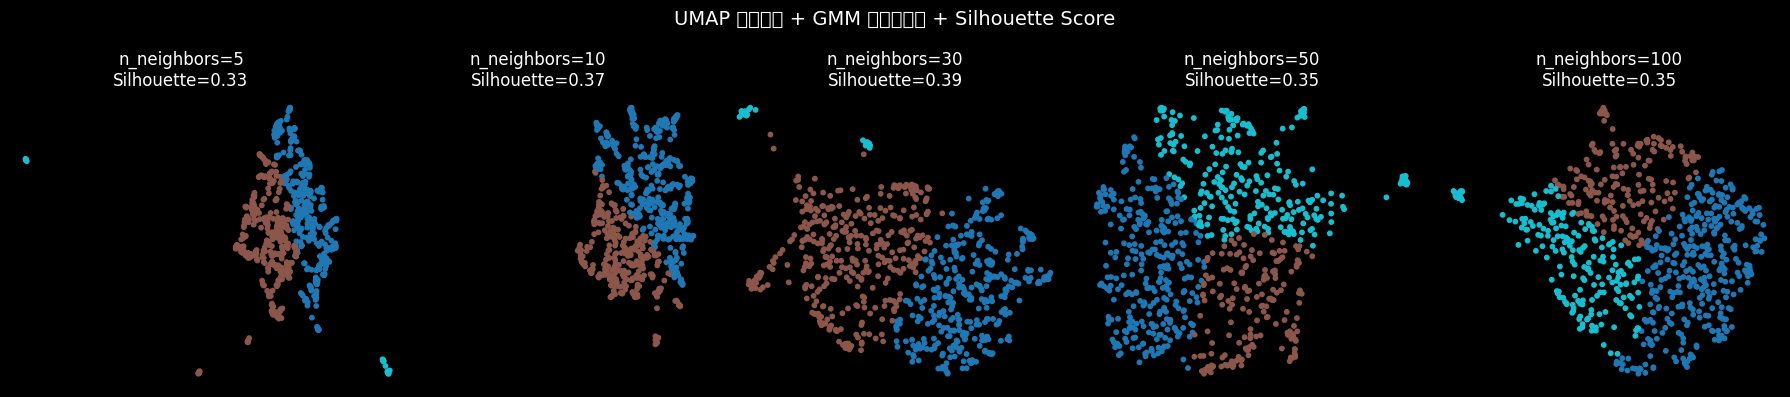

n_neighbors=  5 → Silhouette Score: 0.3336
n_neighbors= 10 → Silhouette Score: 0.3688
n_neighbors= 30 → Silhouette Score: 0.3903
n_neighbors= 50 → Silhouette Score: 0.3510
n_neighbors=100 → Silhouette Score: 0.3531


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 👉 1. 임의의 임베딩 데이터 생성 (또는 실제 임베딩을 여기에 넣으세요)
np.random.seed(42)

# 👉 2. 비교할 n_neighbors 값 목록
n_neighbors_list = [5, 10, 30, 50, 100]

# 👉 3. 결과 저장용 리스트
silhouette_scores = []

# 👉 4. 시각화 및 실루엣 점수 측정
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(18, 4))

for i, n in enumerate(n_neighbors_list):
    reducer = umap.UMAP(n_neighbors=n, n_components=2, metric="cosine", random_state=42)
    reduced = reducer.fit_transform(text_embeddings_np)

    # 클러스터링 (Gaussian Mixture, 3개 군집 가정)
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels = gmm.fit_predict(reduced)

    # 실루엣 점수 계산
    score = silhouette_score(reduced, labels)
    silhouette_scores.append(score)

    # 시각화
    axes[i].scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", s=10)
    axes[i].set_title(f"n_neighbors={n}\nSilhouette={score:.2f}")
    axes[i].axis("off")

plt.suptitle("UMAP 차원축소 + GMM 클러스터링 + Silhouette Score", fontsize=14)
plt.tight_layout()
plt.show()

# 👉 결과 출력
for n, s in zip(n_neighbors_list, silhouette_scores):
    print(f"n_neighbors={n:3d} → Silhouette Score: {s:.4f}")

In [ ]:
reduced

array([[ 31.845215 , -15.417423 ],
       [ 33.45011  , -12.984384 ],
       [ 27.988174 , -13.3660555],
       ...,
       [ 34.903835 , -14.730421 ],
       [ 34.834705 , -14.6645565],
       [ 33.214005 , -15.993488 ]], dtype=float32)

### 최적의 클러스터 수 계산

`get_optimal_clusters` 

- 주어진 임베딩 데이터에 대해 가장 적절한 클러스터 수를 BIC 점수를 기반으로 결정합니다.
- GMM과 BIC를 활용해 클러스터 개수를 자동으로 결정하므로, 사전에 클러스터 수를 지정할 필요가 없습니다.

**과정**

- 가능한 클러스터 수(1 ~ max_clusters 사이)를 순회하며 각 클러스터 개수로 GMM을 학습합니다.
- 각 GMM에 대해 BIC 점수를 계산한 뒤 리스트에 저장합니다.
- BIC 점수가 가장 낮은(가장 좋은 성능을 보이는) 클러스터 개수를 선택하여 반환합니다.

In [ ]:
### 클러스터링에 필요한 "최적의 클러스터 수"를 자동으로 찾아주는 도우미 함수
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """BIC 점수를 기반으로 최적의 클러스터 수를 찾는 함수입니다.
        BIC=-2⋅log(L)+p⋅log(n)
            L: 모델의 우도 (likelihood)
            p: 모델 파라미터 수 (복잡도)
            n: 데이터 개수

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        max_clusters (int, optional): 탐색할 최대 클러스터 수. 기본값은 50
        random_state (int, optional): 난수 생성을 위한 시드값. 기본값은 RANDOM_SEED

    Returns:
        int: BIC 점수가 가장 낮은(최적의) 클러스터 수
    """
    # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    max_clusters = min(max_clusters, len(embeddings))
    # 1부터 최대 클러스터 수까지의 범위를 생성
    n_clusters = np.arange(1, max_clusters)

    # BIC 점수를 저장할 리스트
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        # 학습된 모델의 BIC 점수를 리스트에 추가
        bics.append(gm.bic(embeddings))

    # BIC 점수가 가장 낮은 클러스터 수를 반환
    return n_clusters[np.argmin(bics)]

### 🧮 BIC란?
  ![alt text](222.png)

In [ ]:
get_optimal_clusters(reduced)  # reduced: umap으로 차원 축소한 임베딩값

6

### 클러스터링 수행

`GMM_cluster` 

- GMM을 이용해 주어진 임베딩에 대해 클러스터를 할당합니다.

**과정**

- `get_optimal_clusters` 를 통해 최적의 클러스터 수를 찾습니다.
- `GaussianMixture` 모델을 해당 클러스터 수로 학습합니다.
- 각 데이터 포인트가 각 클러스터에 속할 확률(predict_proba)을 구합니다.
- 주어진 threshold를 바탕으로, 확률이 임계값을 초과하는 클러스터만 레이블로 할당합니다.

In [ ]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    # 최적의 클러스터 수 산정
    n_clusters = get_optimal_clusters(embeddings)

    # 가우시안 혼합 모델을 초기화
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)

    # 임베딩이 각 클러스터에 속할 확률을 예측
    probs = gm.predict_proba(embeddings)

    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
    labels = [np.where(prob > threshold)[0] for prob in probs]

    # 레이블과 클러스터 수를 반환
    return labels, n_clusters

In [ ]:
gm = GaussianMixture(n_components=6, random_state=42)
gm.fit(reduced)

# 임베딩이 각 클러스터에 속할 확률을 예측
probs = gm.predict_proba(reduced)

# 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
labels = [np.where(prob > 0.1)[0] for prob in probs]

print(probs.shape)

(770, 6)


In [ ]:
print(labels[:10])

[array([4], dtype=int64), array([5], dtype=int64), array([2], dtype=int64), array([1, 3, 4], dtype=int64), array([5], dtype=int64), array([0, 5], dtype=int64), array([0, 3], dtype=int64), array([0, 5], dtype=int64), array([0, 5], dtype=int64), array([0, 3], dtype=int64)]


`perform_clustering` 

- 전역 차원 축소, 전역 클러스터링, 이후 로컬 차원 축소 및 로컬 클러스터링까지 전체 클러스터링 파이프라인을 수행하는 핵심 함수입니다.
- 이전의 과정을 하나의 파이프라인으로 만들어 종합하는 역할을 수행합니다.

**과정**

- 입력된 embeddings가 충분한지 확인(적은 경우 단순 할당).
- 전역 차원 축소: `global_cluster_embeddings` 로 전체 임베딩에 대해 UMAP 적용.
- 전역 클러스터링: 전역 차원 축소 결과에 대해 `GMM_cluster` 를 사용하여 전역 클러스터 형성.
- 각 전역 클러스터에 속하는 데이터만 추출 -> 해당 집합에 대해 로컬 차원 축소(`local_cluster_embeddings`) 수행.
- 로컬 차원 축소 결과에 대해 다시 `GMM_cluster` 로 로컬 클러스터링 수행.
- 최종적으로, 각 데이터 포인트에 대해서 전역 및 로컬 클러스터 레이블을 함께 반환합니다.

In [ ]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 계층적 클러스터링을 수행하는 함수입니다.

    전역 차원 축소와 클러스터링을 먼저 수행한 후, 각 전역 클러스터 내에서
    로컬 차원 축소와 클러스터링을 수행합니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        dim (int): 차원 축소 시 목표 차원 수
        threshold (float): GMM 클러스터링에서 사용할 확률 임계값

    Returns:
        List[np.ndarray]: 각 데이터 포인트에 대한 로컬 클러스터 레이블 리스트.
                         각 레이블은 해당 데이터 포인트가 속한 로컬 클러스터의 인덱스를 담은 numpy 배열입니다.
    """

    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        # 임베딩 수가 너무 적으면 클러스터링 무의미 → 각 데이터에 클러스터 0 하나씩 부여하고 종료
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)

    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    # 로컬 클러스터링을 위한 초기화
    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            # 로컬 클러스터 내 특정 데이터가 전체에서 몇 번째인지 역추적해서 all_local_clusters에 클러스터 ID 저장
            # "로컬 클러스터에 속한 특정 임베딩 벡터가 전체 임베딩 중 몇 번째에 있는지 찾는 것"
            ### 예제
            # embeddings: 전체 데이터 (예: 10개)
            # local_cluster_embeddings_: 지금 보고 있는 로컬 클러스터 내의 일부 데이터 (예: 2개)
            # 목적: 이 로컬 데이터들이 전체 중 어디에 있었는지 인덱스를 찾는 것
            # embeddings = np.array([
            #     [1, 2],   # idx 0
            #     [3, 4],   # idx 1
            #     [5, 6],   # idx 2
            #     [7, 8],   # idx 3
            # ])
            # local_cluster_embeddings_ = np.array([
            #     [3, 4],
            #     [7, 8],
            # ])
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            ### Step 1: local_cluster_embeddings_[:, None]
            # local_cluster_embeddings_[:, None].shape = (2, 1, 2)
            # embeddings.shape = (4, 2)
            ### Step 2: (embeddings == local_cluster_embeddings_[:, None])
            # # 결과 예시 (Boolean):
            # array([
            #   [[False, False], [True, True], [False, False], [False, False]],  # [3,4] 비교
            #   [[False, False], [False, False], [False, False], [True, True]],  # [7,8] 비교
            # ])
            ### Step 3: .all(-1)
            # array([
            #   [False, True, False, False],  # [3,4]는 idx=1에서 일치
            #   [False, False, False, True],  # [7,8]는 idx=3에서 일치
            # ])
            ### Step 4: np.where(...)[1]
            # .where()는 True인 위치의 인덱스를 반환
            # axis=1에 대해 True가 있는 곳의 열 인덱스 (즉, 원래 전체에서의 인덱스)
            # np.where(...) → 결과: (array([0, 1]), array([1, 3]))
            # → indices = [1, 3]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### ✅ 전체 구조 요약
# [전체 임베딩]
#  └─ (1) 전역 차원 축소 → [저차원 전역 임베딩]
#  └─ (2) 전역 GMM 클러스터링 → [전역 클러스터 그룹들]
#      └─ (3) 각 전역 클러스터 내부:
#          └─ 로컬 차원 축소 → [저차원 로컬 임베딩]
#          └─ 로컬 GMM 클러스터링 → [로컬 클러스터 그룹들]
#              └─ 최종 클러스터 ID 생성

In [ ]:
local_cluster_embeddings_ = np.array(
    [
        [3, 4],
        [7, 8],
    ]
)
local_cluster_embeddings_[:, None].shape

(2, 1, 2)

In [ ]:
all_local_clusters = perform_clustering(text_embeddings_np, 10, 0.1)

In [ ]:
len(all_local_clusters)

770

In [ ]:
print(dir(all_local_clusters))

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [ ]:
all_local_clusters[:10]

[array([22.]),
 array([60.]),
 array([26., 28., 28., 30., 32., 32., 32., 32., 32., 32.]),
 array([36.]),
 array([17.]),
 array([22.]),
 array([22.]),
 array([62.]),
 array([22.]),
 array([22.])]

주어진 텍스트 리스트를 임베딩 모델을 이용해 벡터로 변환합니다.

In [ ]:
### text_splits 문서를 cached_embeddings 으로 임베딩 벡터로 변환한 후 넘파이 배열로 변환
def embed(texts):
    """







    주어진 텍스트 리스트를 임베딩 벡터로 변환합니다.








    Args:







        texts (List[str]): 임베딩할 텍스트 리스트








    Returns:







        np.ndarray: 텍스트의 임베딩 벡터를 포함하는 numpy 배열







                   shape은 (텍스트 개수, 임베딩 차원)입니다.




    """

    text_embeddings = embeddings.embed_documents(texts)

    # 임베딩을 numpy 배열로 변환

    text_embeddings_np = np.array(text_embeddings)

    return text_embeddings_np

`embed_cluster_texts` 

- 텍스트 리스트를 임베딩하고, 위에서 정의한 클러스터링 절차를 수행한 뒤 결과를 데이터프레임 형태로 반환합니다

**과정**

- embed 함수를 통해 텍스트를 임베딩합니다.
- perform_clustering를 호출하여 클러스터 라벨을 얻습니다.
- 원본 텍스트, 임베딩, 클러스터 정보를 하나의 DataFrame에 통합하여 반환합니다.

In [ ]:
def embed_cluster_texts(texts):
    # 임베딩 생성
    text_embeddings_np = embed(texts)
    # 클러스터링 수행
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)
    # 결과를 저장할 DataFrame 초기화
    df = pd.DataFrame()
    # 원본 텍스트 저장
    df["text"] = texts
    # DataFrame에 리스트로 임베딩 저장
    df["embd"] = list(text_embeddings_np)
    # 클러스터 라벨 저장
    df["cluster"] = cluster_labels
    return df

In [ ]:
df = embed_cluster_texts(texts_split)
df.head(10)

,text,embd,cluster
0,홈페이지 : https://spri.kr/,"[-0.0026174080558121204, -0.023775560781359673...",[68.0]
1,"보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...","[0.03162676468491554, 0.002825413830578327, 0....",[112.0]
2,---,"[0.051134202629327774, 0.002439019037410617, 0...","[34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34...."
3,Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요,"[-0.007292613387107849, -0.01674562506377697, ...",[60.0]
4,- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소,"[0.004773746244609356, 0.03261294960975647, 0....",[12.0]
5,"비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등","[-0.002931874478235841, 0.003207497764378786, ...",[22.0]
6,주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시,"[-0.010457698255777359, 0.025688618421554565, ...",[105.0]
7,"- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,","[0.02209290862083435, -0.019857952371239662, -...",[103.0]
8,모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024,"[0.03472171723842621, -0.006243817508220673, 0...",[22.0]
9,이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지,"[-0.01740691065788269, -0.022478554397821426, ...",[22.0]


`fmt_txt` 함수는 `pandas`의 `DataFrame`에서 텍스트 문서를 단일 문자열로 포맷팅합니다.

In [ ]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    주어진 DataFrame에서 텍스트 문서를 단일 문자열로 포맷팅하는 함수입니다.

    Args:
        df (pd.DataFrame): 포맷팅할 텍스트 문서를 포함한 DataFrame

    Returns:
        str: 텍스트 문서들을 특정 구분자로 결합한 단일 문자열
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

In [ ]:
fmt_txt(df)

'홈페이지 : https://spri.kr/--- --- \n --- --- 보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.--- --- \n --- --- ------ --- \n --- --- Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요--- --- \n --- --- - 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소--- --- \n --- --- 비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등--- --- \n --- --- 주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시--- --- \n --- --- - CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,--- --- \n --- --- 모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024--- --- \n --- --- 이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지--- --- \n --- --- 2024.1.9~12 미국, 라스베가스 https://www.ces.tech/\n- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는--- --- \n --- --- 인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한--- --- \n --- --- 지식과 최신 연구 결과 공유--- --- \n --- --- - 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를--- --- \n --- --- 논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분\nAIMLA 2024--- --- \n --- --- 야의 최첨단 개발 소식 공유\n기간 장소 홈페이지\nhttps://ccnet2024.org/aimla--- --- \n --- --- 2024.1.27~28 덴마크, 코펜하겐\n/index\n- AI 발전 협회 컨퍼런스(AAAI)는 AI 연구를 촉진하고, AI 분야--- --- \n --- -

`embed_cluster_summarize_texts` 

- 텍스트 리스트에 대해 임베딩 → 클러스터링 → 요약 까지 전체 프로세스를 수행합니다.

**과정**

- 임베딩 & 클러스터링: `embed_cluster_texts` 함수를 이용해 입력된 텍스트를 임베딩하고 클러스터링한 결과를 `df_clusters` 로 얻습니다. 이 `df_clusters` 는 각 문서와 그 문서를 할당받은 (하나 이상일 수 있는) 클러스터를 가지고 있습니다.
  
- 클러스터 할당 확장: 어떤 문서가 여러 클러스터에 속할 수 있으므로, 이를 행 단위로 '문서-클러스터' 페어로 확장한 `expanded_df` 를 만듭니다. 이렇게 하면 이후 처리(특히 요약 단계)에서 각 클러스터별로 문서를 쉽게 그룹화할 수 있습니다.

- LLM(대형 언어 모델)을 이용한 요약: 각 클러스터에 속한 문서들의 텍스트를 하나의 문자열로 합친 뒤(`fmt_txt` 사용), 프롬프트 템플릿을 통해 LLM에 전달합니다. LLM은 해당 클러스터에 대한 요약 문장을 생성합니다.

- 요약 결과 정리: 클러스터별 요약 결과를 `df_summary` DataFrame에 저장합니다. 여기에는 summaries(요약문), level(입력 파라미터로 받은 처리 수준), cluster(클러스터 식별자)가 포함됩니다.

In [ ]:
### 🧠 함수의 큰 흐름
# 1. 텍스트 → 임베딩
# 2. 임베딩 → 클러스터링
# 3. 클러스터를 펼쳐서 처리하기 쉽게 변환
# 4. 각 클러스터의 텍스트들을 모아 LLM 요약
# 5. 결과를 두 개의 DataFrame으로 반환
### ✅ 입력과 출력
# 📥 입력
# texts: 텍스트 리스트
# level: 요약의 레벨 정보 (메타데이터용)
# 📤 출력
# df_clusters: 각 텍스트의 임베딩과 클러스터 결과 (원본 기반)
# df_summary: 각 클러스터에 대한 요약 정보 (요약 중심)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """






    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,






    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.







    매개변수:






    - texts: 처리할 텍스트 문서 목록입니다.






    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.







    반환값:






    - 두 개의 데이터프레임을 포함하는 튜플:






      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.






      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.

    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.

    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    ### 결과 예시
    #    text                    cluster
    # 0  "Apple ..."             0
    # 1  "Dog ..."               1

    for index, row in df_clusters.iterrows():

        for cluster in row["cluster"]:

            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.

    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    # 클러스터 ID 추출

    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약

    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    






    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    






    제공된 문서의 자세한 요약을 제공하십시오.
    






    문서:






    {context}
    """

    prompt = ChatPromptTemplate.from_template(template)

    chain = prompt | llm | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.

    summaries = []

    # 각 클러스터마다 요약

    for i in all_clusters:

        df_cluster = expanded_df[expanded_df["cluster"] == i]

        formatted_txt = fmt_txt(df_cluster)

        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.

    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

### 위 함수 📌 시각 요약
  ![alt text](111-2.png)

`recursive_embed_cluster_summarize`
* 텍스트 데이터를 "재귀적으로" 임베딩 → 클러스터링 → 요약하는 함수
* "요약의 요약을 반복해서 점점 압축된 핵심 요약을 얻는 것"
- texts
- │
- ├─ Level 1: embed_cluster_summarize_texts(texts)
- │    ├─ 클러스터링 → 요약
- │    └─ summaries = [요약1, 요약2, ...]
- │
- ├─ Level 2: embed_cluster_summarize_texts(summaries)
- │    ├─ 클러스터링 → 요약
- │    └─ summaries = [요약의 요약1, 요약의 요약2, ...]
- │
- ├─ ...
- │
- └─ Level N: 마지막 재귀

- 텍스트 데이터에 대해 여러 "단계(Level)"에 걸쳐 클러스터링과 요약을 반복적으로 수행합니다.
- 처음에는 원본 텍스트에 대해 클러스터링 및 요약을 수행한 뒤, 각 클러스터 요약을 다음 단계의 입력 텍스트로 삼아 다시 임베딩 → 클러스터링 → 요약을 반복합니다.

In [ ]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    # 각 레벨에서의 결과를 저장할 사전
    results = {}

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()

    # 현재 레벨이 최대 레벨보다 낮고, 유니크한 클러스터가 1개 이상인 경우
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [ ]:
results = recursive_embed_cluster_summarize(texts_split)
len(results)
# results = {
#   1: (df_clusters_1, df_summary_1),  # 원본 텍스트 기준 요약
#   2: (df_clusters_2, df_summary_2),  # 요약의 요약
#   3: (df_clusters_3, df_summary_3),  # 핵심 요약
# }

--Generated 154 clusters--
--Generated 29 clusters--
--Generated 6 clusters--


3

In [ ]:
results

{1: (                                                  text  \
  0                              홈페이지 : https://spri.kr/   
  1    보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...   
  2                                                  ---   
  3                          Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요   
  4               - 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소   
  ..                                                 ...   
  765  ▹ 영국 옥스퍼드 인터넷 연구소, AI 기술자의 임금이 평균 21% 높아······...   
  766  . 주요 행사\n▹CES 2024····························...   
  767  ▹AIMLA 2024···································...   
  768  ▹AAAI Conference on Artificial Intelligence···...   
  769                             --- \n\n\n12\n2023년 월호   
  
                                                    embd  \
  0    [-0.0026456278283149004, -0.02380448393523693,...   
  1    [0.03162676468491554, 0.002825413830578327, 0....   
  2    [0.051134202629327774, 0.002439019037410617, 0...   
  3    [-0.007267317734658718, -0.

전체 문서의 개수를 확인합니다.

In [ ]:
# 전체 문서의 개수
len(texts_split)

770

이제 `recursive_embed_cluster_summarize` 함수를 호출하여 트리 구축을 시작합니다.

- `level=1` 은 첫 번째 단계의 클러스터링 및 요약부터 시작한다는 의미입니다.
- `n_levels=3` 은 최대 세 단계까지(조건이 맞는 한) 클러스터링과 요약을 재귀적으로 반복할 수 있다는 뜻입니다.
- 
결과적으로, 원본 텍스트(leaf_texts)는 먼저 level=1에서 요약되고 클러스터링됩니다. 그 결과로 나온 각 클러스터의 요약이 다음 단계의 입력(level=2)이 되고, 이를 다시 요약하여 클러스터링 한 결과가 level=3 단계의 입력이 될 수 있습니다. 

이 과정을 통해 점차 더 추상적이고 집약된 요약 정보를 얻을 수 있게 됩니다.

In [ ]:
# 트리 구축
leaf_texts = texts_split.copy()

# 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 129 clusters--
--Generated 29 clusters--
--Generated 5 clusters--


In [ ]:
### 레벨이 3개로 나뉘어져 있고, 레벨마다 두 개의 테이블이 있다.
results.keys()

dict_keys([1, 2, 3])

In [ ]:
results[1][0]

,text,embd,cluster
0,홈페이지 : https://spri.kr/,"[-0.0026220136787742376, -0.023787720128893852...",[108.0]
1,"보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...","[0.03161846846342087, 0.002487662248313427, 0....",[72.0]
2,---,"[0.05114144831895828, 0.0024631440173834562, 0...","[34.0, 34.0, 34.0, 35.0, 35.0, 36.0, 36.0, 37...."
3,Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요,"[-0.0072489711456000805, -0.0167401023209095, ...",[42.0]
4,- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소,"[0.004694562405347824, 0.03264385089278221, 0....",[61.0]
...,...,...,...
765,"▹ 영국 옥스퍼드 인터넷 연구소, AI 기술자의 임금이 평균 21% 높아······...","[-0.01683976873755455, 0.016932042315602303, -...",[73.0]
766,. 주요 행사\n▹CES 2024····························...,"[0.005128100048750639, -0.02969302237033844, 0...",[103.0]
767,▹AIMLA 2024···································...,"[0.023226182907819748, -0.015439022332429886, ...",[103.0]
768,▹AAAI Conference on Artificial Intelligence···...,"[0.005623756442219019, -0.02729555033147335, 0...",[104.0]


In [ ]:
results[1][1]

,summaries,level,cluster
0,"제공된 문서는 LangChain 표현 언어에 대한 설명이라기보다는, 5G, AR&V...",1,108.0
1,제공된 문서는 LangChain 표현 언어에 대한 직접적인 설명보다는 AI 정책 및...,1,72.0
2,"제공된 문서는 LangChain 표현 언어에 관한 내용이지만, 실제 문서 내용이 모...",1,34.0
3,"제공된 문서는 LangChain 표현 언어에 관한 내용이지만, 실제 문서 내용이 모...",1,35.0
4,"제공된 문서는 LangChain 표현 언어에 관한 내용으로, LangChain에서 ...",1,36.0
...,...,...,...
124,"제공된 문서는 LangChain 표현 언어에 대한 설명을 시작하려는 의도로 보이나,...",1,64.0
125,제공된 문서는 LangChain 표현 언어에 대한 설명보다는 법원 판결과 관련된 내...,1,62.0
126,"제공된 문서는 LangChain 표현 언어에 대한 설명을 시작하는 부분과, 저작권 ...",1,67.0
127,제공된 문서는 미국 바이든 대통령이 2023년 10월 30일 발표한 ‘안전하고 신뢰...,1,74.0


In [ ]:
results[3][0]

,text,embd,cluster
0,제공된 문서들은 LangChain 표현 언어에 대한 구체적이고 실질적인 설명이나 체...,"[-0.004334051627665758, 0.03586605563759804, -...",[3.0]
1,제공된 여러 문서들은 모두 **LangChain 표현 언어 자체에 대한 구체적 설명...,"[0.02327398769557476, 0.03808298334479332, -0....",[4.0]
2,"제공된 문서는 LangChain 표현 언어에 관한 내용임을 알 수 있으나, 실제 문...","[0.01372564397752285, 0.031900860369205475, -0...",[2.0]
3,"제공된 여러 단편적 문서 내용을 종합하면, LangChain 표현 언어는 다음과 같...","[0.02473674714565277, 0.04862183704972267, -0....",[0.0]
4,제공된 문서들은 주로 EU 내 AI 법(AI Act) 제정 및 기반모델(Founda...,"[0.015201035887002945, 0.04443379491567612, 0....",[1.0]
5,제공된 문서들은 모두 LangChain 표현 언어에 대한 구체적 설명이나 체인 구성...,"[0.015847740694880486, 0.018610192462801933, -...",[4.0]
6,제공된 문서들은 모두 LangChain 표현 언어에 대한 직접적인 설명이나 체인 구...,"[0.022804930806159973, 0.05258014053106308, -0...",[4.0]
7,"제공된 문서는 LangChain 표현 언어에 대한 직접적이고 구체적인 설명보다는, ...","[0.016360556706786156, 0.05305593088269234, -0...",[2.0]
8,"제공된 문서는 LangChain 표현 언어에 관한 내용의 일부로, LangChain...","[0.01755683869123459, 0.02638312242925167, 0.0...",[0.0]
9,"제공된 문서들은 LangChain 표현 언어에 대한 설명이 아니라, AI 기술과 시...","[0.010195399634540081, 0.04058496654033661, -0...",[4.0]


다음으로는 vectorstore를 생성하고 로컬에 저장합니다.
* texts_split 문서에 요약본을 넣고 모든 문서내용을 vectorstore에 저장

In [ ]:
leaf_texts[:10]

['홈페이지 : https://spri.kr/',
 '보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.',
 '---',
 'Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요',
 '- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소',
 '비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등',
 '주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시',
 '- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,',
 '모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024',
 '이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지']

In [ ]:
from langchain_community.vectorstores import FAISS

all_texts = leaf_texts.copy()

# 레벨을 정렬하여 순회
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embeddings)

In [ ]:
len(all_texts)

933

In [ ]:
all_texts[-10:]

['제공된 문서는 LangChain 표현 언어에 대해 간략히 소개하며, 이 언어가 LangChain 내에서 체인을 구성하는 방법을 제공한다는 점을 알립니다. 문서에서는 특히 에이전트(agent) 기술의 발전과 보급이 컴퓨터 분야를 넘어 산업 전반에 걸쳐 큰 변화를 가져올 것임을 강조합니다. 키보드 입력에서 아이콘 클릭으로의 변화 이후, 에이전트의 등장이 사용자 경험과 작업 흐름에 중대한 전환점이 될 것임을 시사합니다. 그러나 문서 자체는 LangChain 표현 언어의 구체적인 구조, 문법, 사용법 등에 대한 상세한 설명이나 예시는 포함하지 않고 있어, 실제 언어의 작동 방식이나 활용법에 대한 정보는 부족한 상태입니다. 요약하면, 문서는 LangChain 표현 언어의 개념적 역할과 에이전트 기술의 중요성을 소개하는 데 그치고 있습니다.',
 '제공된 문서는 크게 두 부분으로 구성되어 있습니다.\n\n1. **LangChain 표현 언어에 대한 설명**  \n   - LangChain 표현 언어는 LangChain 프레임워크 내에서 체인을 구성하는 방법을 정의하는 언어입니다.  \n   - 이를 통해 사용자는 다양한 컴포넌트(예: LLM, 도구, API 호출 등)를 연결하여 복잡한 작업 흐름을 설계하고 실행할 수 있습니다.  \n   - 문서에서는 LangChain 표현 언어가 체인 구성의 핵심 역할을 하며, 이를 통해 자동화 및 확장 가능한 애플리케이션 개발이 가능함을 시사합니다.\n\n2. **생성 AI와 저작권 관련 법적 이슈**  \n   - 문서 후반부에는 생성 AI(특히 이미지 생성 모델)와 관련된 저작권 분쟁 사례가 포함되어 있습니다.  \n   - 여러 예술가들이 AI 기업을 상대로 저작권 침해 소송을 제기했으나, 법원은 증거 불충분 및 저작권 미등록 등을 이유로 소송을 기각했습니다.  \n   - 법원은 AI가 생성한 이미지가 단일 원저작물의 파생물이 아니며, AI 훈련에 사용된 이미지들에 모두 저작권이 있다고 보지 않는 입장을 취하고 있습니다. 

DB 를 로컬에 저장합니다.


In [ ]:
import os

DB_INDEX = "RAPTOR"

# 기존 DB 인덱스가 존재하면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embeddings)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

`vectorstore` 로부터 `retriever`를 생성합니다.

In [ ]:
# retriever 생성
retriever = vectorstore.as_retriever()

## RAG 체인 정의

이제 생성된 vectorstore를 이용해 RAG 체인을 정의하고 실행하여 결과를 확인합니다.

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

# 프롬프트 정의
prompt = PromptTemplate.from_template(
    """
    You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
You are given PDF documents. Your primary mission is to answer questions based on provided context.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names).

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.

# Output Format:
[General introduction of the answer]
[Comprehensive answer to the question]

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

[Note]
- Answer should be written in Korean.

# Your final ANSWER to the user's QUESTION:"""
)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(f"<document>{doc.page_content}</document>" for doc in docs)


# RAG 체인 정의
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

[LangSmith 링크](https://smith.langchain.com/public/e5acd315-a662-4f93-aec3-04c80a8bd2a4/r)

In [ ]:
# 추상적인 질문 실행
answer = rag_chain.stream("AI관련 해당 문서가 다루는 주요 내용에 대해 정리해주세요.")
stream_response(answer)

제공된 문서들은 LangChain 표현 언어 자체에 대한 구체적인 설명, 문법, 사용법, 체인 구성 방법을 포함하지 않고, AI 정책, 안전, 윤리, 연구, 경제적 영향, 기술 동향, AI 에이전트 활용, 데이터 문제 등 AI 전반에 관한 다양한 주제를 다루고 있습니다.

주요 내용은 다음과 같습니다.

1. **AI 정책 및 안전**  
   - AI 안전 연구 촉진, AI 규제 강화, 소비자 보호, 차별 방지, 책임 있는 AI 사용 모범사례 개발(형사사법, 주택, 의료 분야)  
   - AGI 위험 평가 및 사회적 영향 분석, 이해관계자 협력체계 구축

2. **AI 기술 및 연구 동향**  
   - AI 및 기계학습 이론과 실무 연구, 첨단 AI 시스템 개발, AI 모델 성능 평가 및 환각 문제 분석  
   - 주요 기업(구글, MS, 오픈AI, 앤스로픽) AI 모델 개발 및 투자 현황  
   - AI 에이전트의 산업별 활용과 서비스 대중화

3. **AI 경제적 영향 및 시장 동향**  
   - AI 소프트웨어 시장 급성장 전망, AI 기술자 임금 프리미엄, 기업들의 AI 투자 확대  
   - AI 기술 간 결합성 및 경제적 가치 강조

4. **데이터 및 모델 훈련 문제**  
   - 데이터 출처 불명확성, 편향 문제, 민감 정보 처리, AI 모델 취약점 및 위험 완화 방안  
   - 고성능 컴퓨팅 및 초고속 네트워크 활용 현황

5. **LangChain 표현 언어 관련**  
   - LangChain 표현 언어는 체인 구성 도구로 간략히 언급되나, 구체적 문법, 사용법, 예시는 제공되지 않음  
   - 관련 기술 및 생태계 전반에 관한 단편적 정보만 포함

결론적으로, 문서들은 LangChain 표현 언어의 구체적 내용보다는 AI 정책, 연구, 안전, 윤리, 경제, 기술 동향 등 AI 전반에 관한 광범위한 주제를 포괄적으로 다루고 있습니다. LangChain 표현 언어의 상세 정보는 별도의 전문 자료를 참고해야 합니다.

[LangSmith 링크](https://smith.langchain.com/public/bf58bdc0-ae03-4793-89ed-3d2bc95bd331/r)

In [ ]:
# mid level 질문 실행
answer = rag_chain.stream("Anthropic 에 투자 관련된 내용을 요약하세요.")
stream_response(answer)

Anthropic에 대한 투자 내용은 구글이 20억 달러를 투자했으며, 구글 칩을 활용하는 확장된 파트너십을 통해 AI 스타트업 Anthropic과 협력하고 있다는 점입니다.

[LangSmith 링크](https://smith.langchain.com/public/d2869acc-ac9b-4d4d-85b9-33a73b43b535/r)

In [ ]:
# Low Level 질문 실행
answer = rag_chain.stream("삼성전자가 개발한 생성형 AI 의 이름과 발표일은?")
stream_response(answer)

삼성전자가 개발한 생성형 AI의 이름은 ‘삼성 가우스’이며, 발표일은 2023년 11월 8일이다.